### Data needed to run this code can be found on the Sequence Read Archive under BioProject PRJNA643848

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
from collections import defaultdict
import pandas as pd
import math
import matplotlib.patches as patch
import pysam
import os
import csv
import re
from termcolor import cprint
import xlsxwriter
import numpy as np
from scipy.stats import binom_test
import logomaker
import random

import warnings
warnings.filterwarnings('ignore')

In [2]:
# specify various colors for plotting
blue = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
red = (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)
green = (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)
purple = (0.5058823529411764, 0.4470588235294118, 0.6980392156862745)
gold = (0.8, 0.7254901960784313, 0.4549019607843137)
cyan = (0.39215686274509803, 0.7098039215686275, 0.803921568627451)

# used to convert numerical indices to base letter indices in dataframes
index = [0, 1, 2, 3]
index2 = ['A', 'C', 'G', 'T']
# directory where data files are stored
data_dir = '../../../data/'
# directory to print figures to
figurePrint_dir = '/Users/jelacqua/Desktop/'
printFigures = False

# specify various parameters for plot style
sns.set(context = "paper", style = "white")
sns.set_context("paper", rc = {"lines.linewidth": 2, 'axes.labelsize': 8, 'text.fontsize': 8, 'legend.fontsize': 8,
            'xtick.labelsize': 8, 'ytick.labelsize': 8, 'text.usetex': False})
plt.rcParams['axes.prop_cycle'] = plt.cycler(color = [blue, green, red, purple])

### Figure 2

In [3]:
def readFastq(fileName):
    #Return all read names, bases, and quality scores stored in input fastq file
    readNames = []
    readBases = []
    readQualities = []
    with gzip.open(fileName) as file:
        text = file.readlines()
        # for each line in the file, extract the read information
        for i in range(0, len(text), 4):
            readNames.append(text[i][:-1])
            readBases.append(text[i + 1][:-1])
            readQualities.append(text[i + 2][:-1])
    return readNames, readBases, readQualities

def reverseComplement(seq):
    #Return reverse complement of DNA sequence input as a string
    if type(seq) == str:
        return seq.replace('G', 'X').replace('C', 'G').replace('X', 'C').replace('A', 'X').replace('T', 'A').replace('X', 'T')[::-1]
    else:
        return seq.replace(b'G', b'X').replace(b'C', b'G').replace(b'X', b'C').replace(b'A', b'X').replace(b'T', b'A').replace(b'X', b'T')[::-1]

def baseTransitions(seq):
    #Return sequence as a string with A/G replacing one another and C/T replacing one another
    return seq.replace('G', 'X').replace('A', 'G').replace('X', 'A').replace('C', 'X').replace('T', 'C').replace('X', 'T')

def processRead(seq, qual, startIndex, length, rc = False, qcutoff = 30):
    #Return read trimmed to positions specified by startIndex and length, removing low quality base calls
    
    if rc:
        seq = reverseComplement(seq)

    # read is the sequence of 'length' bases around the nick
    read = list(seq[startIndex:startIndex + length].decode('ascii'))

    # only keep reads with high quality score
    q = list(qual[startIndex:startIndex + length])
    for i in range(len(q)):
        # subtracting 33 from quality scores converts from ascii to actual quality score (e.g. F becomes 37)
        if q[i] - 33 < qcutoff:
            read[i] == 'N'

    # valid is a quality control check
    # don't use the current sequence if neither of these sets of 3 nucleotides in the oligo is correct
    valid = seq[startIndex - 8:startIndex - 5] == b'CCA' or seq[startIndex - 5:startIndex - 2] == b'AGG'

    return ''.join(read), valid

def countOligoBases(files, startIndex = 28, length = 17, rc = False):
    #Return base call counts in specified fastq files at all loci indicated by startIndex in length
    bases = []
    for file in files:
        counter = 0
        library = defaultdict(str)
        _, seqs, quals = readFastq(file)
        for i in range(len(seqs)):
            seqs[i], qc = processRead(seqs[i], quals[i], startIndex, length, rc)
            # if current sequence passed quality control check
            if qc:
                # add current sequence (only 'length' nucleotides around the nick) to the library
                library[counter] = [j for j in seqs[i]]
                counter += 1

        temp = pd.DataFrame.from_dict(library, orient = 'index')
        ini = pd.DataFrame(temp[0].value_counts())

        # for each position in the library, ini stores the number of times each nucleotide occurred
        for item in range(1, temp.shape[1]):
            ini = pd.concat([ini, pd.DataFrame(temp[item].value_counts())], axis = 1)
        ini.loc['N'] = 0
        temp = ini / ini.sum(axis = 0)[0]
        bases.append(temp.fillna(0))
    return bases

def plotOligo(bases, title = [], figsize = [3.373, 5.656]):
    #Plot histograms of base occurrence at each position
    plt.figure(figsize = figsize)
    for i in range(1, len(bases) + 1):
        for sample in range(1, len(bases[i - 1]) + 1):
            ax = plt.subplot(len(bases[i - 1]), len(bases), (sample - 1) * len(bases) + i)
            ax.grid(False)
            plt.ylim([0, 1.05])
            ini = bases[i - 1][sample - 1]
            # plot bar for fraction of each base at current position
            p1 = plt.bar(ini.columns, ini.loc['A'], edgecolor = blue, label = 'A')
            p2 = plt.bar(ini.columns, ini.loc['C'], bottom = ini.loc['A'], edgecolor = green, label = 'C')
            p3 = plt.bar(ini.columns, ini.loc['T'], bottom = ini.loc['A'] + ini.loc['C'], edgecolor = red, label = 'T')
            p4 = plt.bar(ini.columns, ini.loc['G'], bottom = ini.loc['A'] + ini.loc['C'] + ini.loc['T'], edgecolor = purple, label='G')
            if i == 1:
                plt.ylabel('Fraction of reads')
                plt.yticks([0, 0.25, 0.5, 0.75, 1])
            else:
                plt.yticks([])
            if i == len(bases) and sample == 1:
                ax.legend(loc = "upper left", bbox_to_anchor = (1, 1))
            if sample == 1 and title:
                plt.title(title[i - 1], fontsize = 8)
            if sample == len(bases[i - 1]):
                plt.xlabel('Base position / Expected base')
                plt.xticks(ini.columns, [str(j - 3) + '\n' + seq[j] for j in ini.columns])
            else:
                plt.xticks([])
    sns.despine()

In [4]:
# load data for oligo experiment with PCR by Taq DNA Polymerase
taq = countOligoBases([data_dir + 'fig2/oligo_dPTP_dKTP_taqPCR_nickAt' + i + '_R2.fastq.gz' for i in 'GTCA'])
# load data for oligo experiment with PCR by KAPA HiFi DNA Polymerase
kapa = countOligoBases([data_dir + 'fig2/oligo_dPTP_dKTP_kapaPCR_nickAt' + i + '_R2.fastq.gz' for i in 'GTCA'])
seq = 'TGAGTCACTTGCGCATT'

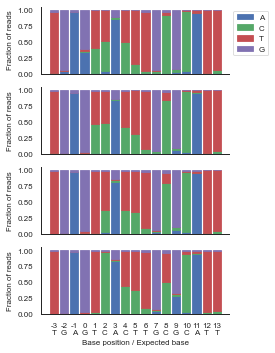

In [5]:
# plot base frequencies when PCR is done with Taq
plotOligo([taq])
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_2B.pdf', bbox_inches = 'tight', transparent = 'True')

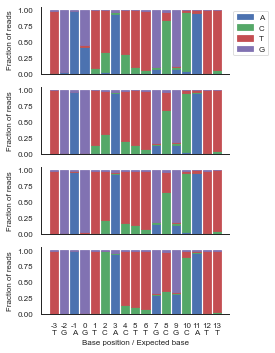

In [6]:
# plot base frequencies when PCR is done with KAPA HiFi
plotOligo([kapa])
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_2C.pdf', bbox_inches = 'tight', transparent = 'True')

### Figure 3

In [7]:
def plotCircle(length, topNicks = [], topColors = [], topOffsets = [], bottomNicks = [], bottomColors = [], bottomOffsets = [], fontsize = 18):
    #Plot two circles (representing double-stranded DNA) and triangles pointing to nicked loci
    plt.axes()

    # plot concentric black and white circles to get the two DNA strands
    circle = plt.Circle((0, 0), radius = 2, fc = 'k')
    plt.gca().add_patch(circle)
    circle = plt.Circle((0, 0), radius = 1.9, fc = 'w')
    plt.gca().add_patch(circle)
    circle = plt.Circle((0, 0), radius = 1.8, fc = 'k')
    plt.gca().add_patch(circle)
    circle = plt.Circle((0, 0), radius = 1.7, fc = 'w')
    plt.gca().add_patch(circle)

    # t determines size of triangles pointing to nick loci in the diagram
    t = 0.35

    # write length of DNA sequence in middle of circles
    plt.text(0, 0, format(length, ',') + ' bp', horizontalalignment = 'center', verticalalignment = 'center', fontsize = fontsize)

    # plot triangles pointing to nicks on reference strand (outer strand in the diagram)
    i = 0
    for nick in topNicks:
        angle = math.pi * (0.5 - 2 * nick / length)
        # offset is to make a triangle farther from the DNA so it doesn't overlap another triangle, if necessary
        if topOffsets and topOffsets[i]:
            # trigonometry to determine locations of the triangle's corners
            locs = (((2 + t * 0.75 ** 0.5) * math.cos(angle), (2 + t * 0.75 ** 0.5) * math.sin(angle)), \
                    ((2 + t * 3 ** 0.5) * math.cos(angle) - (t / 2) * math.cos(math.pi / 2 - angle), (2 + t * 3 ** 0.5) * math.sin(angle) + (t / 2) * math.sin(math.pi / 2 - angle)), \
                    ((2 + t * 3 ** 0.5) * math.cos(angle) + (t / 2) * math.cos(math.pi / 2 - angle), (2 + t * 3 ** 0.5) * math.sin(angle) - (t / 2) * math.sin(math.pi / 2 - angle)))
        else:
            # trigonometry to determine locations of the triangle's corners
            locs = ((2 * math.cos(angle), 2 * math.sin(angle)), \
                    ((2 + t * 0.75 ** 0.5) * math.cos(angle) - (t / 2) * math.cos(math.pi / 2 - angle), (2 + t * 0.75 ** 0.5) * math.sin(angle) + (t / 2) * math.sin(math.pi / 2 - angle)), \
                    ((2 + t * 0.75 ** 0.5) * math.cos(angle) + (t / 2) * math.cos(math.pi / 2 - angle), (2 + t * 0.75 ** 0.5) * math.sin(angle) - (t / 2) * math.sin(math.pi / 2 - angle)))
        # plot triangle in specified color (e.g. red for on-target nicking and purple for off-target nicking)
        if len(topColors) == 1:
            triangle = patch.Polygon(locs, clip_on = False, color = topColors[0])
        else:
            triangle = patch.Polygon(locs, clip_on = False, color = topColors[i])
        plt.gca().add_patch(triangle)
        i += 1
        
    # plot triangles pointing to nicks on non-reference strand (inner strand in the diagram)
    i = 0
    for nick in bottomNicks:
        angle = math.pi * (0.5 - 2 * nick / length)
        # offset is to make a triangle farther from the DNA so it doesn't overlap another triangle, if necessary
        if bottomOffsets and bottomOffsets[i]:
            # trigonometry to determine locations of the triangle's corners
            locs = (((1.7 - t * 0.75 ** 0.5) * math.cos(angle), (1.7 - t * 0.75 ** 0.5) * math.sin(angle)), \
                    ((1.7 - t * 3 ** 0.5) * math.cos(angle) - (t / 2) * math.cos(math.pi / 2 - angle), (1.7 - t * 3 ** 0.5) * math.sin(angle) + (t / 2) * math.sin(math.pi / 2 - angle)), \
                    ((1.7 - t * 3 ** 0.5) * math.cos(angle) + (t / 2) * math.cos(math.pi / 2 - angle), (1.7 - t * 3 ** 0.5) * math.sin(angle) - (t / 2) * math.sin(math.pi / 2 - angle)))
        else:
            # trigonometry to determine locations of the triangle's corners
            locs = ((1.7 * math.cos(angle), 1.7 * math.sin(angle)), \
                    ((1.7 - t * 0.75 ** 0.5) * math.cos(angle) - (t / 2) * math.cos(math.pi / 2 - angle), (1.7 - t * 0.75 ** 0.5) * math.sin(angle) + (t / 2) * math.sin(math.pi / 2 - angle)), \
                    ((1.7 - t * 0.75 ** 0.5) * math.cos(angle) + (t / 2) * math.cos(math.pi / 2 - angle), (1.7 - t * 0.75 ** 0.5) * math.sin(angle) - (t / 2) * math.sin(math.pi / 2 - angle)))
        # plot triangle in specified color (e.g. red for on-target nicking and purple for off-target nicking)
        if len(bottomColors) == 1:
            triangle = patch.Polygon(locs, clip_on = False, color = bottomColors[0])
        else:
            triangle = patch.Polygon(locs, clip_on = False, color = bottomColors[i])
        plt.gca().add_patch(triangle)
        i += 1

    plt.axis('scaled')
    plt.axis('off')

In [8]:
def countBaseFrequency(file, chromosome, qThreshold = 30):
    #Return fraction of each base that is called at each position, ignoring low quality read calls
    
    # read all base calls above the quality threshold
    samfile = pysam.AlignmentFile(file)
    c = samfile.count_coverage(chromosome, quality_threshold = qThreshold)
    samfile.close()
    
    # convert base calls to a dataframe indexed by base letter instead of number (e.g. A instead of 0)
    cov = pd.DataFrame()
    for i in index:
        cov = pd.concat([cov, pd.DataFrame(c[i].tolist()).T])
    cov.index = index2
    
    readCount = cov.sum(axis = 0)
    return [cov / cov.sum(axis = 0), readCount]

def countCoverage(file, construct = None, mapQFilter = 0):
    #Return read coverage, filling in for whole DNA fragments inferred from the paired-end alignments
    samfile = pysam.AlignmentFile(file)
    header = str(samfile.header)
    # extract the length of the reference
    if construct is None:
        ln = header.index('LN:') + 3
        loopThrough = samfile
    else:
        ln = header.index('LN:', header.index(construct)) + 3
        loopThrough = samfile.fetch(construct)
    ln = int(header[ln:header.index('\n', ln)])
    # loop through all reads to count coverage
    cov = np.array([0] * ln)
    for read in loopThrough:
        if read.is_proper_pair and read.mapping_quality >= mapQFilter:
            start = read.reference_start
            mateStart = read.next_reference_start
            # infer full length of read from the paired end alignments
            if start > mateStart or (start == mateStart and read.mate_is_reverse):
                cov[mateStart:read.reference_end] += 1
    samfile.close()
    return cov

def getData(file, chromosome, ext = ['.sorted.bam', '.noDup.bam']):
    #Return fraction of base calls at each position and read coverage
    return countBaseFrequency(file + ext[0], chromosome), countCoverage(file + ext[1])

def readReference(file):
    #Return reference sequence (or multiple sequences) from fasta file(s)
    
    # if file is a fasta
    if file[-6:] == '.fasta' or file[-3:] == '.fa':
        # read all text in file
        with open(file) as textfile:
            tempRef = textfile.readlines()
        # determine number of constructs present in file based on number of times '>' character appears
        indices = [i for i in range(len(tempRef)) if '>' in tempRef[i]]
        # if only one construct return the whole reference as a string
        if len(indices) == 1:
            return ''.join(tempRef[1:]).replace('\n', '').upper()
        # if multiple constructs store all references as strings in a dictionary and return the dictionary
        else:
            reference = dict()
            for i in range(len(indices) - 1):
                reference[tempRef[indices[i]][1:-1]] = ''.join(tempRef[indices[i] + 1:indices[i + 1]]).replace('\n', '')
            reference[tempRef[indices[-1]][1:-1]] = ''.join(tempRef[indices[-1] + 1:]).replace('\n', '')
            return reference
    # if file is a directory
    else:
        reference = dict()
        # loop through all files in directory
        for f in os.listdir(file):
            with open(file + '/' + f) as textfile:
                # add current file's reference to the reference dictionary
                temp = textfile.readlines()
                reference[f[:f.rfind('.')]] = ''.join(temp).replace('\n', '')[len(f) - 2:]
        return reference

def hammingDistance(seq1, seq2):
    #Return hamming distance between two sequences of equal length
    
    # assert that the sequences are of equal length
    if len(seq1) != len(seq2):
        raise Exception('Sequences must be the same length.')
    # count number of loci where the sequences differ from one another, ignoring loci where either is an 'N'
    dist = 0
    for i in range(len(seq1)):
        if seq1[i] != seq2[i] and seq1[i] != 'N' and seq2[i] != 'N':
            dist = dist + 1
    return dist

def loadPeaks(file = data_dir + 'fig5/Ecoli_genome_peaks.xls', skip = 23):
    #Return data for all MACS2 called peaks stored in the input file
    peaks = dict()
    peaks['chromosome'] = []
    peaks['start'] = []
    peaks['end'] = []
    peaks['logP'] = []
    peaks['logQ'] = []
    peaks['pileup'] = []
    peaks['enrichment'] = []
    with open(file) as csvfile:
        reader = csv.reader(csvfile)
        # skip header of the file
        for i in range(skip):
            next(reader)
        # for each subsequent row in the file, extract all data for that MACS peak
        for row in reader:
            text = row[0].split('\t')
            peaks['chromosome'].append(text[0])
            peaks['start'].append(int(text[1]))
            peaks['end'].append(int(text[2]))
            peaks['logP'].append(float(text[6]))
            peaks['logQ'].append(float(text[8]))
            peaks['pileup'].append(int(round(float(text[5]))))
            peaks['enrichment'].append(float(text[7]))
    return pd.DataFrame(peaks)

In [9]:
# load data for plasmid experiment where no nicking treatment is used
controlBases, controlCov = getData(data_dir + 'fig3/plasmid_noNicks', 'plasmid_pilon')
controlBases = controlBases[0]
# load data for plasmid experiment where Nb.BsmI nicking endonuclease is used
expBases, expCov = getData(data_dir + 'fig3/plasmid_NbBsmI', 'plasmid_pilon')
expBases = expBases[0]

# load plasmid reference and identify sites where dPTP or where dKTP would be inserted during nick translation
plasmidReference = readReference(data_dir + 'fig3/pilon_psrM01.fasta')
p = [i in 'CT' for i in plasmidReference]
k = [i in 'AG' for i in plasmidReference]

# identify on-target sites for Nb.BsmI based on reference sequence
ontargets = []
for match in re.finditer('GAATGC', plasmidReference):
    ontargets.append(match.start() + 4.5)
for match in re.finditer(reverseComplement('GAATGC'), plasmidReference):
    ontargets.append(match.start() + 0.5)

# call MACS2 on dataset (if needed, can also be done beforehand in Terminal) and load the called peaks
# os.system('macs2 callpeak -t ' + data_dir + 'fig3/plasmid_NbBsmI.sorted.bam -g 7305 --nomodel -n ' + data_dir + 'fig3/plasmid_NbBsmI')
plasmidPeaks = loadPeaks(data_dir + 'fig3/plasmid_NbBsmI_peaks.xls')
peakBounds = sorted(list(plasmidPeaks.start) + list(plasmidPeaks.end))

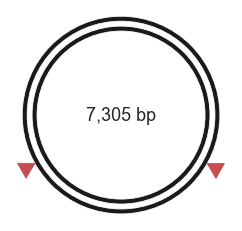

In [10]:
# plot diagram of expected Nb.BsmI on-target nicks
plotCircle(len(plasmidReference), ontargets, [red])
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_3A.pdf', bbox_inches = 'tight', transparent = 'True')

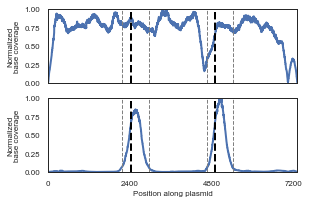

In [11]:
# plot normalized coverage for the non-nicked and nicked plasmid data

plt.figure(figsize = (4.462, 3))

cov = [controlCov, expCov]
for i in range(2):
    plt.subplot(2, 1, i + 1)
    # normalize coverage data to be between 0 and 1, then plot
    plt.plot(range(len(cov[i])), cov[i] / max(cov[i]))
    plt.ylim((0, 1))
    plt.xlim((0, len(cov[i])))
    plt.yticks([0, 0.25, 0.5, 0.75, 1])
    if i == 0:
        plt.xticks([])
        plt.xlabel('')
    else:
        plt.xticks([0, 2400, 4800, 7200])
        plt.xlabel('Position along plasmid')
    plt.ylabel('Normalized\nbase coverage')

    # put black dashed lines at expected nick sites
    for i in ontargets:
        plt.axvline(i, ls = 'dashed', color = 'black')

    # put gray dashed lines at MACS2 peak bounds
    for i in peakBounds:
        plt.axvline(i, ls = 'dashed', color = 'gray', lw = 1)
    
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_3B.pdf', bbox_inches = 'tight', transparent = 'True')

In [12]:
def plotPlasmidTransitions(loci, nick, xticks, xlab = True):
    #Plot base call transition mutation rate for the specified loci
    
    plt.figure(figsize = (3.538, 1.8))
    
    # determine transition rate from the base calls and the reference sequence
    transition = baseTransitions(plasmidReference)
    y = [expBases[i][transition[i]] for i in range(loci[0], loci[1] + 1)]
    yControl = [controlBases[i][transition[i]] for i in range(loci[0], loci[1] + 1)]
    
    # plot sites where dPTP would be incorporated in blue
    plt.scatter([i for i in range(loci[0], loci[1] + 1) if p[i]], [y[i] for i in range(len(y)) if p[i + loci[0]]])
    # plot sites where dKTP would be incorporate in green
    plt.scatter([i for i in range(loci[0], loci[1] + 1) if k[i]], [y[i] for i in range(len(y)) if k[i + loci[0]]])
    # plot data for non-nicked control in gray
    plt.scatter(range(loci[0], loci[1] + 1), yControl, c = 'gray', s = 10)

    plt.xlim([loci[0] - 0.5, loci[1] + 0.5])
    plt.ylim([-0.02, 0.35])
    plt.yticks([0, 0.1, 0.2, 0.3])
    plt.xticks(xticks)
    if xlab:
        plt.xlabel('Position along plasmid')
    plt.ylabel('Base call\ntransition error rate')

    # put a black dashed line at the nick site
    plt.axvline(nick, ls = 'dashed', color = 'black', lw = 1)

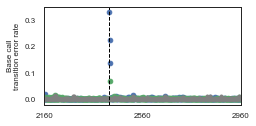

In [13]:
# plot transition mutation rate for the left MACS2 peak in the plasmid data
plotPlasmidTransitions(peakBounds[:2], ontargets[0], range(2160, 2961, 400), False)
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_3C_top.pdf', bbox_inches = 'tight', transparent = 'True')

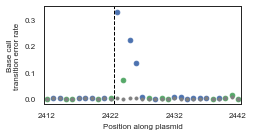

In [14]:
# zoomed in view of the above plot around the nick site
plotPlasmidTransitions([int(ontargets[0] - 10.5), int(ontargets[0] + 19.5)], ontargets[0], range(2412, 2443, 10))
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_3C_bottom.pdf', bbox_inches = 'tight', transparent = 'True')

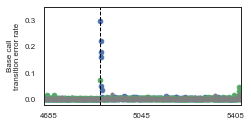

In [15]:
# plot transition mutation rate for the right MACS2 peak in the plasmid data
plotPlasmidTransitions(peakBounds[2:], ontargets[1], range(4685, 5406, 360), False)
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_3D_top.pdf', bbox_inches = 'tight', transparent = 'True')

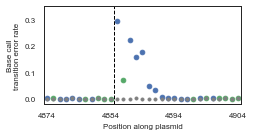

In [16]:
# zoomed in view of the above plot around the nick site
plotPlasmidTransitions([int(ontargets[1] - 10.5), int(ontargets[1] + 19.5)], ontargets[1], range(4874, 4905, 10))
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_3D_bottom.pdf', bbox_inches = 'tight', transparent = 'True')

### Figure 4

In [17]:
def offtarget_NbBsmI_calls(bases):
    #Returns Nb.BsmI off-target calls given the base frequency at each position in the plasmid
    
    # determine transition rate from the base calls and the reference sequence
    pk = [bases[i].loc[transition[i]] for i in range(len(plasmidReference))]

    # identify potential off-target sites based on hamming distance between plasmid reference and Nb.BsmI target sequence
    locs1 = []
    locs2 = []
    for i in range(len(plasmidReference) - 7):
        if hammingDistance(plasmidReference[i:i + 7], 'NGCATTC') < 2:
            # reference strand potential off-target between the G and C of the on-target sequence
            locs1.append(i + 1)
        elif hammingDistance(plasmidReference[i:i + 7], 'GAATGCN') < 2:
            # non-reference strand potential off-target between the G and C of the on-target sequence
            locs2.append(i + 4)

    topNicks = [-100]
    topNicks2 = [-100]
    bottomNicks = []
    bottomNicks2 = []
    erroneousNickCalls = []
    # loop thropugh all sites in plasmid
    for i in range(len(plasmidReference)):
        # if transition mutation rate is above a certain threshold, it is determined to be due to a nick
        if pk[i] > 0.012:
            # if the current locus is in locs1, this is a reference strand off-target
            if i in [1 + j for j in locs1]:
                topNicks.append(i - 1)
            # if the current locus is in loc2, this is a non-reference strand off-target
            elif i in locs2:
                bottomNicks.append(i)
            else:
                # if a reference strand nick has been called just 5' of the current locus, high signal here is due to dPTP/dKTP extension from that locus
                if i == topNicks[-1] + 2 or i == topNicks2[-1] + 2:
                    topNicks2.append(i - 1)
                # if a non-reference strand nick is just 3' of the current locus, high signal here is due to dPTP/dKTP extension from that locus
                elif any([i in range(j - 3, j) for j in locs2]):
                    bottomNicks2.append(i)
                # if none of the above are true, a false-positive nick call has been made
                else:
                    erroneousNickCalls.append(i)
    # remove first element from topNicks and topNicks2 since the lists were created with a placeholder value of -100
    del topNicks[0]
    del topNicks2[0]
    # make sure all called nicks represent off-target Nb.BsmI activity and not false-positive calls
    assert not erroneousNickCalls
    # return reference strand and non-reference strand off-target calls
    return topNicks, bottomNicks

In [18]:
# load plasmid reference sequence and identify transition bases expected to result from dPTP/dKTP
plasmidReference = readReference(data_dir + 'fig3/pilon_psrM01.fasta')
transition = baseTransitions(plasmidReference)

# load data for plasmid nicked by Nb.BsmI that displays nicking endonuclease off-target activity
# original reads were mapped to a reference that contained two copies of the plasmid reference
# this helped enable proper mapping at the "beginning" and "end" of the reference sequence (since the reference is an artificially linear representation of circular DNA)
plasmidOffBases, plasmidOffCov = getData(data_dir + 'fig4/plasmid_NbBsmI_withOfftargets', 'plasmid_pilon')
plasmidOffBases = pd.concat([plasmidOffBases[0].iloc[:, 7305:10956], plasmidOffBases[0].iloc[:, 3651:7305]], axis = 1)
plasmidOffBases.columns = range(7305)
plasmidOffCov = np.concatenate([plasmidOffCov[7305:10956], plasmidOffCov[3651:7305]])

# call MACS2 on dataset (if needed, can also be done beforehand in Terminal) and load the called peaks
# os.system('macs2 callpeak -t ' + data_dir + 'fig4/plasmid_NbBsmI_withOfftargets.sorted.bam -f BAMPE -q 0.95 -g 7305 --nomodel -n ' + data_dir + 'fig4/plasmid_NbBsmI_withOfftargets')
plasmidPeaks2 = loadPeaks(data_dir + 'fig4/plasmid_NbBsmI_withOfftargets_peaks.xls')
peakBounds2 = []
peakBounds2.append(plasmidPeaks2.start[2] - 7305)
peakBounds2.append(plasmidPeaks2.end[2] - 7305)
peakBounds2.append(plasmidPeaks2.start[1])
peakBounds2.append(plasmidPeaks2.end[1])
peakQ2 = list(plasmidPeaks2.logQ[2:0:-1])

# identify off-target nick loci
topNicks, bottomNicks = offtarget_NbBsmI_calls(plasmidOffBases)

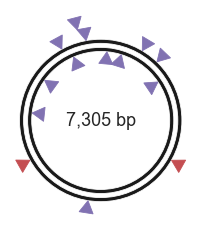

In [19]:
# plot diagram of expected Nb.BsmI on-target nicks and the identified off-targets
plotCircle(len(plasmidReference), topNicks = topNicks, topColors = [red if i in [2422, 4884] else purple for i in topNicks], topOffsets = [i == 7011 for i in topNicks], bottomNicks = bottomNicks, bottomColors = [purple])
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_4A.pdf', bbox_inches = 'tight', transparent = 'True')

In [20]:
def plotPlasmidOffTargets(bases, cov, onTargets, topOffTargets = [], bottomOffTargets = [], macs2Peaks = [], reference = [], plotBaseCallsOnlyInPeaks = False):
    #Plot normalized coverage and transition mutation rates for the plasmid off-target data
    
    fig = plt.figure(figsize = (3.468, 5.005))

    # if transition mutation rate is plotted only in peaks, a grid is made with one column in the top row and two columns in the bottom row
    if plotBaseCallsOnlyInPeaks:
        grid = plt.GridSpec(2, 2)
        plt.subplot(grid[0, :])
        plt.xticks(range(0, len(cov), round(len(cov) - 100, -2) // 3))
    # if transition mutation rate is plotted across the whole plasmid, there is just a top row and bottom row each with a single column
    else:
        plt.subplot(2, 1, 1)
        plt.xticks([])
    # normalize coverage data to be between 0 and 1, then plot
    plt.plot(range(len(cov)), cov / max(cov))
    plt.ylim((0, 1))
    plt.xlim((0, len(cov)))
    plt.yticks([0, 0.25, 0.5, 0.75, 1])
    plt.ylabel('Normalized base coverage')

    # put purple dashed lines at reference strand off-targets
    for i in topOffTargets:
        plt.axvline(i, c = purple, ls = 'dashed', ymin = 0, linewidth = 1)
    # put cyan dashed lines at non-reference strand off-targets
    for i in bottomOffTargets:
        plt.axvline(i, c = cyan, ls = 'dashed', ymin = 0, linewidth = 1)
    # put black dashed lines at on-targets
    for i in onTargets:
        plt.axvline(i, c = 'k', ls = 'dashed', ymin = 0, linewidth = 1)
    # put gray dashed lines at MACS2 peak bounds
    for i in macs2Peaks:
        plt.axvline(i, c = 'gray', ls = 'dashed', ymin = 0, linewidth = 1)

    # plot transition mutation rate, either in the MACS2 peaks individually or across the whole plasmid
    transition = baseTransitions(reference)
    if plotBaseCallsOnlyInPeaks:
        # plot data for the left peak
        plt.subplot(grid[1, 0])
        plt.scatter(range(macs2Peaks[0], macs2Peaks[1] + 1), [bases[i][transition[i]] for i in range(macs2Peaks[0], macs2Peaks[1] + 1)], s = 24)
        plt.ylim((0, 0.5))
        plt.xlim((macs2Peaks[0], macs2Peaks[1]))
        plt.xticks([macs2Peaks[0], macs2Peaks[1]])
        plt.yticks([0, 0.25, 0.5])
        plt.ylabel('Base call\ntransition error rate')
        # plot dashed lines to signify on-target and off-target nicks
        for i in topOffTargets:
            if i >= macs2Peaks[0] and i < macs2Peaks[1]:
                plt.axvline(i, c = purple, ls = 'dashed', ymin = 0, linewidth = 1)
        for i in bottomOffTargets:
            if i >= macs2Peaks[0] and i < macs2Peaks[1]:
                plt.axvline(i, c = cyan, ls = 'dashed', ymin = 0, linewidth = 1)
        for i in onTargets:
            if i >= macs2Peaks[0] and i < macs2Peaks[1]:
                plt.axvline(i, c = 'k', ls = 'dashed', ymin = 0, linewidth = 1)
        
        # plot data for the right peak
        plt.subplot(grid[1, 1])
        plt.scatter(range(macs2Peaks[2], macs2Peaks[3] + 1), [bases[i][transition[i]] for i in range(macs2Peaks[2], macs2Peaks[3] + 1)], s = 24)
        plt.ylim((0, 0.5))
        plt.xlim((macs2Peaks[2], macs2Peaks[3]))
        plt.yticks([])
        plt.xticks([macs2Peaks[2], macs2Peaks[3]])
        # plot dashed lines to signify on-target and off-target nicks
        for i in topOffTargets:
            if i >= macs2Peaks[2] and i < macs2Peaks[3]:
                plt.axvline(i, c = purple, ls = 'dashed', ymin = 0, linewidth = 1)
        for i in bottomOffTargets:
            if i >= macs2Peaks[2] and i < macs2Peaks[3]:
                plt.axvline(i, c = cyan, ls = 'dashed', ymin = 0, linewidth = 1)
        for i in onTargets:
            if i >= macs2Peaks[2] and i < macs2Peaks[3]:
                plt.axvline(i, c = 'k', ls = 'dashed', ymin = 0, linewidth = 1)
        
        fig.text(0.5, 0.075, 'Position along plasmid', va = 'center', ha = 'center', fontsize = 8)
    else:
        # plot data for the whole plasmid
        plt.subplot(2, 1, 2)
        plt.scatter(range(len(cov)), [bases[i][transition[i]] for i in range(len(cov))], s = 24)
        plt.xlim((0, len(cov)))
        plt.xticks(range(0, len(cov), round(len(cov) - 100, -2) // 3))
        plt.ylim((0, 0.5))
        plt.yticks([0, 0.25, 0.5])
        plt.xlabel('Position along plasmid')
        plt.ylabel('Base call\ntransition error rate')
        # plot dashed lines to signify on-target and off-target nicks, and MACS2 peak bounds
        for i in topOffTargets:
            plt.axvline(i, c = purple, ls = 'dashed', ymin = 0, linewidth = 1)
        for i in bottomOffTargets:
            plt.axvline(i, c = cyan, ls = 'dashed', ymin = 0, linewidth = 1)
        for i in onTargets:
            plt.axvline(i, c = 'k', ls = 'dashed', ymin = 0, linewidth = 1)
        for i in macs2Peaks:
            plt.axvline(i, c = 'gray', ls = 'dashed', ymin = 0, linewidth = 1)

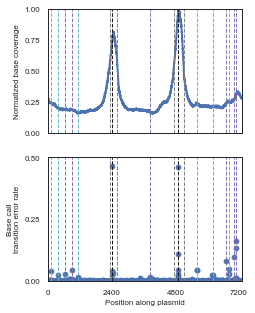

In [21]:
# plot base coverage and transition mutation rate for the whole plasmid
plotPlasmidOffTargets(plasmidOffBases, plasmidOffCov, [2422, 4884], [i for i in topNicks if i not in [2422, 4884]], bottomNicks, peakBounds2, plasmidReference)
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_4C.pdf', bbox_inches = 'tight', transparent = 'True')

In [22]:
# print out information concerning each identified nick

# all called nicks are inserted into a dataframe
temp = pd.DataFrame()
temp['loci'] = topNicks + bottomNicks
locs = [i for i in temp.loci if i not in [2422, 4884]]
locs.sort()
temp['strand'] = [True] * len(topNicks) + [False] * len(bottomNicks)
temp['signal'] = 0
temp['seq'] = 0
temp['n'] = 0
for i in temp.index:
    # on-target and off-targets are numbered based on their loci in the plasmid
    if temp.loc[i, 'loci'] == 2422:
        temp.loc[i, 'n'] = 'On target 1'
    elif temp.loc[i, 'loci'] == 4884:
        temp.loc[i, 'n'] = 'On target 2'
    else:
        temp.loc[i, 'n'] = 'Off target ' + str(np.where(locs == temp.loc[i, 'loci'])[0][0] + 1)
       
    # transition signal at the site just proximal to the nick is extracted
    locus = temp.loc[i, 'loci'] + temp.loc[i, 'strand']
    temp.loc[i, 'signal'] = plasmidOffBases[locus].loc[baseTransitions(plasmidReference[locus])]
    
    # plasmid sequence targeted by Nb.BsmI (with up to one mismatch to the on-target sequence) is extracted
    if temp.loc[i, 'strand']:
        temp.loc[i, 'seq'] = reverseComplement(plasmidReference[temp.loc[i, 'loci'] - 1:temp.loc[i, 'loci'] + 6])
    else:
        temp.loc[i, 'seq'] = plasmidReference[temp.loc[i, 'loci'] - 4:temp.loc[i, 'loci'] + 3]
temp = temp.sort_values('signal', ascending = False)

target = 'GAATGCN'
# print header row
print('Name\t\tLocus\tStrand\tSequence\tTransition rate\t\t-log(MACS2 q score)')
for _, row in temp.iterrows():
    # print nick name and locus
    print(row.n + '\t' + str(row.loci), end = '\t')
    # print nick strand
    if row.strand:
        print('+', end = '\t')
    else:
        print('-', end = '\t')
    # print target sequence, mismatches to the on-target sequence are colored red
    for i in range(len(target)):
        if target[i] == 'N' or target[i] == row.seq[i]:
            cprint(row.seq[i], 'blue', end = '')
        else:
            cprint(row.seq[i], 'red', end = '')
    # print transition mutation rate
    print('\t\t' + str(row.signal), end = '\t')
    # print MACS2 q score of peak that contains the nick, if applicable
    if row.loci == 2422:
        print(peakQ2[0])
    elif row.loci == 4884:
        print(peakQ2[1])
    else:
        print('n.a.')

Name		Locus	Strand	Sequence	Transition rate		-log(MACS2 q score)
On target 1	2422	+	GAATGCG		0.4643551740325934	331.68753
On target 2	4884	+	GAATGCC		0.4615655675811729	833.05078
Off target 12	7095	+	GAACGCG		0.13563659628918745	n.a.
Off target 11	7011	+	GAATGAC		0.0988042794210195	n.a.
Off target 9	6726	+	GGATGCT		0.07994955863808323	n.a.
Off target 10	6836	-	GGATGCA		0.04880952380952381	n.a.
Off target 7	5605	-	GAACGCC		0.044005544005544	n.a.
Off target 4	889	+	AAATGCC		0.0430786904078116	n.a.
Off target 1	105	-	GAATGTG		0.042616033755274264	n.a.
Off target 3	625	+	GACTGCC		0.0279305966991113	n.a.
Off target 8	6201	-	GAGTGCC		0.02555366269165247	n.a.
Off target 2	354	-	GAATGTC		0.02284626368396002	n.a.
Off target 5	1138	-	GAATGAC		0.017179023508137433	n.a.
Off target 6	3835	+	AAATGCA		0.016329704510108865	n.a.


In [23]:
# prints the same data as above, but to a Microsoft Excel file
if printFigures:
    # create file for printing
    workbook = xlsxwriter.Workbook(figurePrint_dir + 'Table_S2.xlsx')
    worksheet = workbook.add_worksheet()
    b = workbook.add_format({'color': 'blue'})
    r = workbook.add_format({'color': 'red'})

    worksheet.write(0, 0, 'Nicking endonuclease Nb.BSMI recognition sequence: GAATGCN')

    # print header row
    headings = ['Name', 'Locus', 'Strand', 'Sequence', 'Transition rate', '-log(MACS2 q score)']
    for i in range(len(headings)):
        worksheet.write(2, i, headings[i])

    count = 2
    for _, row in temp.iterrows():
        count += 1
        # print nick name
        worksheet.write(count, 0, row.n)
        # print nick locus
        worksheet.write(count, 1, row.loci)
        # print nick strand
        if row.strand:
            worksheet.write(count, 2, '+')
        else:
            worksheet.write(count, 2, '-')
        # print target sequence, mismatches to the on-target sequence are colored red
        f = []
        for i in range(len(target)):
            if target[i] == 'N' or target[i] == row.seq[i]:
                f.append(b)
            else:
                f.append(r)
        worksheet.write_rich_string(count, 3, '', f[0], row.seq[0], f[1], row.seq[1], f[2], row.seq[2], f[3], row.seq[3], f[4], row.seq[4], f[5], row.seq[5], f[6], row.seq[6])
        # print transition mutation rate
        worksheet.write(count, 4, row.signal)
        # print MACS2 q score of peak that contains the nick, if applicable
        if row.loci == 2422:
            worksheet.write(count, 5, str(peakQ2[0]))
        elif row.loci == 4884:
            worksheet.write(count, 5, str(peakQ2[1]))
        else:
            worksheet.write(count, 5, 'n.a.')

    workbook.close()

In [24]:
# load data for plasmid nicked by Cas9 nickase
plasmidReference2 = readReference(data_dir + 'fig4/pMN00_targetInsertAAVS1.fasta')
plasmidCas9Bases, plasmidCas9Cov = getData(data_dir + 'fig4/plasmid_cas9nickase', 'pMN00_target')

# identify on-target and off-target nick loci based on plasmid reference and guide RNA
cas9nicks = []
for match in re.finditer('ACTAGGGACAGGAT', plasmidReference2):
    cas9nicks.append(match.start() + 10.5)
for match in re.finditer(reverseComplement('ACTAGGGACAGGAT'), plasmidReference2):
    cas9nicks.append(match.start() + 2.5)

# call MACS2 on dataset (if needed, can also be done beforehand in Terminal) and load the called peaks
# os.system('macs2 callpeak -t ' + data_dir + 'fig4/plasmid_cas9nickase.sorted.bam -f BAMPE -q 0.95 -g 7305 --nomodel -n ' + data_dir + 'fig4/plasmid_cas9nickase')
plasmidPeaks3 = loadPeaks(data_dir + 'fig4/plasmid_cas9nickase_peaks.xls')
peakBounds3 = sorted(list(plasmidPeaks3.start) + list(plasmidPeaks3.end))
peakQ3 = list(plasmidPeaks3.logQ)

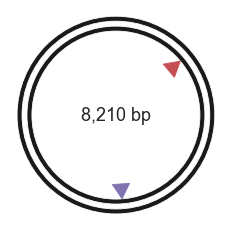

In [25]:
# plot diagram of expected Cas9 nickase on-target nick and the identified off-target
plotCircle(len(plasmidReference2), bottomNicks = cas9nicks, bottomColors = [red, purple])
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_4C.pdf', bbox_inches = 'tight', transparent = 'True')

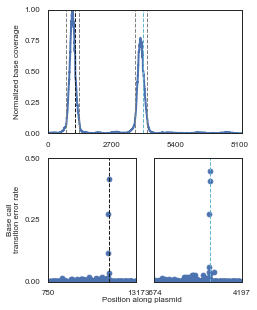

In [26]:
# plot base coverage for the whole plasmid and transition mutation rate just within the MACS peaks
plotPlasmidOffTargets(plasmidCas9Bases[0], plasmidCas9Cov, [cas9nicks[0]], [], [cas9nicks[1]], peakBounds3, plasmidReference2, True)
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_4D.pdf', bbox_inches = 'tight', transparent = 'True')

In [27]:
# print out information concerning each identified nick

target = 'GGGGCCACTAGGGACAGGAT'
# print header row
print('Name\t\tLocus\tStrand\tSequence\t\tPAM\t-log(MACS2 q score)\tTransition rate')

# print 'On target', the nick locus, and the nick strand
print('On target\t' + str(round(cas9nicks[0])) + '\t-', end = '\t')
# print target sequence, mismatches to the on-target sequence are colored red
seq = plasmidReference2[round(cas9nicks[0]) - 17:round(cas9nicks[0]) + 6]
for i in range(len(target)):
    if target[i] == 'N' or target[i] == seq[i]:
        cprint(seq[i], 'blue', end = '')
    else:
        cprint(seq[i], 'red', end = '')      
locus = round(cas9nicks[0]) - 1
# print PAM sequence
cprint('\t' + seq[-3:], 'blue', end = '\t')
# print MACS2 q score of peak containing nick and the transition mutation rate
print(str(peakQ3[0]) + '\t\t' + str(plasmidCas9Bases[0][locus].loc[baseTransitions(plasmidReference2[locus])]))

# print 'Off target', the nick locus, and the nick strand
print('Off target\t' + str(round(cas9nicks[1])) + '\t-', end = '\t')
# print target sequence, mismatches to the on-target sequence are colored red
seq = plasmidReference2[round(cas9nicks[1]) - 17:round(cas9nicks[1]) + 6]
for i in range(len(target)):
    if target[i] == 'N' or target[i] == seq[i]:
        cprint(seq[i], 'blue', end = '')
    else:
        cprint(seq[i], 'red', end = '')
locus = round(cas9nicks[1]) - 1
# print PAM sequence
cprint('\t' + seq[-3:], 'blue', end = '\t')
# print MACS2 q score of peak containing nick and the transition mutation rate
print(str(peakQ3[1]) + '\t\t' + str(plasmidCas9Bases[0][locus].loc[baseTransitions(plasmidReference2[locus])]))

Name		Locus	Strand	Sequence		PAM	-log(MACS2 q score)	Transition rate
On target	1142	-	GGGGCCACTAGGGACAGGAT	TGG	90.17108		0.6097059179474767
Off target	4010	-	AGCTTTACTAGGGACAGGAT	TGG	70.17111		0.4453575799965029


In [28]:
# prints the same data as above, but to a Microsoft Excel file
if printFigures:
    # create file for printing
    workbook = xlsxwriter.Workbook(figurePrint_dir + 'Table_S3.xlsx')
    worksheet = workbook.add_worksheet()
    b = workbook.add_format({'color': 'blue'})
    r = workbook.add_format({'color': 'red'})

    worksheet.write(0, 0, 'guide RNA sequence: GGGGCCACTAGGGACAGGAT')

    # print header row
    headings = ['Name', 'Locus', 'Strand', 'Sequence', 'PAM', '-log(MACS2 q score)', 'Transition rate']
    for i in range(len(headings)):
        worksheet.write(2, i, headings[i])

    seq = plasmidReference2[round(cas9nicks[0]) - 17:round(cas9nicks[0]) + 6]
    # print 'On target'
    worksheet.write(3, 0, 'On target')
    # print nick locus
    worksheet.write(3, 1, str(round(cas9nicks[0])))
    # print nick strand
    worksheet.write(3, 2, '-')
    # print target sequence, mismatches to the on-target sequence are colored red
    f = []
    for i in range(len(target)):
        if target[i] == 'N' or target[i] == seq[i]:
            f.append(b)
        else:
            f.append(r)
    worksheet.write_rich_string(3, 3, '', f[0], seq[0], f[1], seq[1], f[2], seq[2], f[3], seq[3], f[4], seq[4], f[5], seq[5], f[6], seq[6], f[7], seq[7], f[8], seq[8], f[9], seq[9], f[10], seq[10], f[11], seq[11], f[12], seq[12], f[13], seq[13], f[14], seq[14], f[15], seq[15], f[16], seq[16], f[17], seq[17], f[18], seq[18], f[19], seq[19])
    # print PAM sequence
    worksheet.write_rich_string(3, 4, '', b, seq[-3:])
    # print MACS2 q score of peak containing nick
    worksheet.write(3, 5, peakQ3[0])
    locus = round(cas9nicks[0]) - 1
    # print transition mutation rate
    worksheet.write(3, 6, str(plasmidCas9Bases[0][locus].loc[baseTransitions(plasmidReference2[locus])]))

    seq = plasmidReference2[round(cas9nicks[1]) - 17:round(cas9nicks[1]) + 6]
    # print 'Off target'
    worksheet.write(4, 0, 'Off target')
    # print nick locus
    worksheet.write(4, 1, str(round(cas9nicks[1])))
    #print nick strand
    worksheet.write(4, 2, '-')
    # print target sequence, mismatches to the on-target sequence are colored red
    f = []
    for i in range(len(target)):
        if target[i] == 'N' or target[i] == seq[i]:
            f.append(b)
        else:
            f.append(r)
    worksheet.write_rich_string(4, 3, '', f[0], seq[0], f[1], seq[1], f[2], seq[2], f[3], seq[3], f[4], seq[4], f[5], seq[5], f[6], seq[6], f[7], seq[7], f[8], seq[8], f[9], seq[9], f[10], seq[10], f[11], seq[11], f[12], seq[12], f[13], seq[13], f[14], seq[14], f[15], seq[15], f[16], seq[16], f[17], seq[17], f[18], seq[18], f[19], seq[19])
    # print PAM sequence
    worksheet.write_rich_string(4, 4, '', b, seq[-3:])
    # print MACS2 q score of peak containing nick
    worksheet.write(4, 5, peakQ3[1])
    locus = round(cas9nicks[1]) - 1
    # print transition mutation rate
    worksheet.write(4, 6, str(plasmidCas9Bases[0][locus].loc[baseTransitions(plasmidReference2[locus])]))

    workbook.close()

### Figure 5

In [29]:
# loads all data for the E. coli genome and identifies nicks

# load data for E. coli genome nicked by Cas9 nickase
genomeBases, genomeCov = getData(data_dir + 'fig5/Ecoli_genome', 'contig000001')
readCount = genomeBases[1]
genomeBases = genomeBases[0]

# read genome reference
genomeReference = readReference(data_dir + 'fig5/Escherichia_coli_ATCC_11303.fasta')
guideRNA1 = 'GGTCTCCCCATGCGAGAGTA'
guideRNA2 = 'GATCTCCCTGGCGTCGCTGG'

# cutoff q value for MACS2 peaks to be considered, can be changed to zero, won't affect result
qCutoff = 0.4
# minimum read count at nick site for a nick to be called, can be changed to zero, won't affect result
minReadCount = np.percentile(readCount[readCount > 0], 10)

# call MACS2 on dataset (if needed, can also be done beforehand in Terminal) and load the called peaks
# os.system('macs2 callpeak -t ' + data_dir + 'fig5/Ecoli_genome.sorted.bam -f BAMPE -q 0.95 -g 4600000 -n ' + data_dir + 'fig5/Ecoli_genome')
peaks = loadPeaks()
temp = peaks[peaks.logQ > qCutoff]
# print fraction of genome captured within MACS2 peaks
print(str(round(sum(peaks.end - peaks.start + 1) / len(genomeReference) * 100, 2)) + '% of genome in a peak')
print(str(round(sum(temp.end - temp.start + 1) / len(genomeReference) * 100, 2)) + '% of genome in a high quality peak\n')
# print number of MACS2 peaks
print(str(len(peaks)) + ' MACS2 peaks')
print(str(len(temp)) + ' MACS2 peaks with good enough quality score')

# determine significance of the observed transition mutation rate at all loci in MACS2 peaks
# this method will use binomial tests to determine the probability of observing the transition mutation rate
# null hypothesis for each binomial test is the maximum of 0.05 and the observed transversion mutation rate
p1 = [1] * len(genomeCov)
p2 = [1] * len(genomeCov)
for _, peak in peaks[peaks.logQ > qCutoff].iterrows():
    for i in range(peak.start - 3, peak.end + 4):
        if not np.isnan(genomeBases[i][baseTransitions(genomeReference[i])]):
            # if genome reference contains A or G
            if genomeReference[i] in 'AG':
                # null hypothesis is maximum of observed C base calls, T base calls, or 0.05
                nullHypothesis = np.nanmax([genomeBases[i]['C'], genomeBases[i]['T'], 0.05])
            # if genome reference contains C or T
            else:
                # null hypothesis is maximum of observed A base calls, G base calls, or 0.05
                nullHypothesis = np.nanmax([genomeBases[i]['A'], genomeBases[i]['G'], 0.05])
            # perform binomial test with determined null hypothesis value
            p1[i] = binom_test(round(genomeBases[i][baseTransitions(genomeReference[i])] * readCount[i]), readCount[i], nullHypothesis, alternative = 'greater')
            if np.isnan(p1[i]):
                p1[i] = 1
    
    # for each of the binomial test values, a sort of median filter is applied to remove random standalone values
    for i in range(peak.start, peak.end):
        p2[i] = min(sorted(p1[i - 3:i + 1])[1], sorted(p1[i:i + 4])[1])

# identify possible nick locations based off low probability of multiple transition mutational signals occuring by chance close to one another
# potential nick calls begin simply as loci where the binomial test gave a significant enough p value
possibleNicks = np.where(np.array(p2) < 1e-10)[0]
# group potential nick locations if they are close together
# multiple consecutive "potential nicks" from earlier are actually consecutive dPTP/dKTP insertions at one nick site
spacing = possibleNicks[1:] - possibleNicks[:-1]
possibleNicks2 = []
temp = 0
# consecutive "potential nicks" become a signal nick call that contains the first and last loci with observable signal
# the actual nick could be at either end of this range, its exact location is determined later with the strandedness
for nickIndex in range(len(spacing)):
    if spacing[nickIndex] > 5:
        possibleNicks2.append([possibleNicks[temp], possibleNicks[nickIndex]])
        temp = nickIndex + 1
possibleNicks2.append([possibleNicks[temp], possibleNicks[-1]])

# transition mutation rates are calculated for all of the potential nick calls
pkSignal = [0] * len(genomeCov)
for i in possibleNicks2:
    for j in range(i[0] - 10, i[1] + 11):
        temp = np.nanmax(genomeBases[j])
        if np.isnan(temp) or temp == 0:
            pkSignal[j] = 0
        else:
            pkSignal[j] = genomeBases[j][baseTransitions(genomeReference[j])] / genomeBases[j][genomeReference[j]]
# extend possible nick identifications out up to 5 base pairs if there is weaker dPTP/dKTP signal outside of the strong signal used to originally identify the nick
for i in range(len(possibleNicks2)):
    temp = [j for j in range(possibleNicks2[i][0] - 5, possibleNicks2[i][1] + 6) if pkSignal[j] > 0.02]
    possibleNicks2[i] = [temp[0], temp[-1]]
print(str(len(possibleNicks2)) + ' potential nicks based on degenerate signal')
# remove low read count areas
for i in range(len(possibleNicks2) - 1, -1, -1):
    if np.mean(readCount[possibleNicks2[i][0]:possibleNicks2[i][1] + 1]) <= minReadCount:
        del possibleNicks2[i]
print(str(len(possibleNicks2)) + ' potential nicks after removing low read count regions')
# remove areas that could be mutations
for i in range(len(possibleNicks2) - 1, -1, -1):
    for j in range(possibleNicks2[i][0], possibleNicks2[i][1] + 1):
        temp = baseTransitions(genomeReference[j])
        if genomeBases[j][genomeReference[j]] == 0 or genomeBases[j][temp] > genomeBases[j][genomeReference[j]] * 10:
            del possibleNicks2[i]
            break
print(str(len(possibleNicks2)) + ' potential nicks after removing expected mutations contributing to degenerate signal')
# remove sites with low dPTP/dKTP signal
for i in range(len(possibleNicks2) - 1, -1, -1):
    temp = np.array(pkSignal[possibleNicks2[i][0]:possibleNicks2[i][1] + 1])
    length = possibleNicks2[i][1] - possibleNicks2[i][0] + 1
    # delete if small fraction of bases in range show mutational signal
    if not (sum(temp > 0.01) / length >= 0.6 or sum(temp > 3.5) / length >= 0.25):
        del possibleNicks2[i]
    # delete if small absolute number of bases in range show mutational signal
    elif not ((sum(temp > 0.01) >= 5) or sum(temp > 3.5) >= 2):
        del possibleNicks2[i]
print(str(len(possibleNicks2)) + ' potential nicks after removing sites with low dPTP/dKTP signal\n')

# for each called nick, strandedness must now be determined
calledNicks = []
strand = []
peaks['nicksContained'] = 0
for i in possibleNicks2:
    # determine MACS2 peak that contains the current nick
    peak = peaks[(peaks.start < i[0]) & (peaks.end > i[1])]
    peaks.loc[peak.index, 'nicksContained'] += 1
    peak = peak.iloc[0]
    # if this is not the first nick identified in this MACS2 peak
    if peak.nicksContained > 0:
        # identify locus of maximum coverage in this MACS2 peak 5' of the nick
        # this will be the sub-peak in the MACS2 called peak associated with the other nick in the MACS2 peak
        temp = np.argmax(genomeCov[peak.start:i[0]]) + peak.start
        # identify the locus of minimum coverage between the above identified locus and the nick
        # this will identify the beginning of the sub-peak associated with this nick
        temp = np.argmin(genomeCov[temp:i[0]]) + temp
        # identify location of maximum coverage 3' of the above identified locus
        # this locus will be compared to the nick location
        temp = np.argmax(genomeCov[temp:peak.end + 1]) + temp
        # nick locus is 5' of the coverage peak, this is a reference strand nick
        if temp > i[1]:
            calledNicks.append(i[0])
            strand.append('top')
        # nick locus is 3' of the coverage peak, this is a non-reference strand nick
        else:
            calledNicks.append(i[1])
            strand.append('bottom')
    # if this is the first nick identified in this MACS2 peaks
    else:
        # compare location of the nick to location with highest read coverage
        temp = np.argmax(genomeCov[peak.start:peak.end + 1]) + peak.start
        # nick locus is 5' of the coverage peak, this is a reference strand nick
        if temp > i[1]:
            calledNicks.append(i[0])
            strand.append('top')
        # nick locus is 3' of the coverage peak, this is a non-reference strand nick
        else:
            calledNicks.append(i[1])
            strand.append('bottom')

# print information on each of the called nicks
for i in range(len(calledNicks)):
    # print nick locus and strand
    print('Nick at locus ' + str(calledNicks[i]) + ', ' + strand[i] + ' strand.', end = '\t')
    # get guide RNA target sequence based on which strand contains the nick
    if strand[i] == 'bottom':
        temp = genomeReference[calledNicks[i] - 16:calledNicks[i] + 8]
    else:
        temp = reverseComplement(genomeReference[calledNicks[i] - 7:calledNicks[i] + 17])
    # print if there is complementarity to the guide RNA and what the PAM is
    if hammingDistance(temp[:23], guideRNA1 + 'NGG') == 0 or hammingDistance(temp[1:], guideRNA1 + 'NGG') == 0:
        print('Perfect complementarity to guide RNA 1, NGG PAM.')
    elif hammingDistance(temp[:23], guideRNA1 + 'NGG') == 0 or hammingDistance(temp[1:], guideRNA2 + 'NGG') == 0:
        print('Perfect complementarity to guide RNA 2, NGG PAM.')

21.48% of genome in a peak
14.85% of genome in a high quality peak

3267 MACS2 peaks
1976 MACS2 peaks with good enough quality score
196 potential nicks based on degenerate signal
192 potential nicks after removing low read count regions
93 potential nicks after removing expected mutations contributing to degenerate signal
9 potential nicks after removing sites with low dPTP/dKTP signal

Nick at locus 231867, bottom strand.	Perfect complementarity to guide RNA 1, NGG PAM.
Nick at locus 1142933, bottom strand.	Perfect complementarity to guide RNA 2, NGG PAM.
Nick at locus 2646965, top strand.	Perfect complementarity to guide RNA 1, NGG PAM.
Nick at locus 3349191, top strand.	Perfect complementarity to guide RNA 1, NGG PAM.
Nick at locus 3349437, top strand.	Perfect complementarity to guide RNA 1, NGG PAM.
Nick at locus 3906462, bottom strand.	Perfect complementarity to guide RNA 1, NGG PAM.
Nick at locus 4016944, bottom strand.	Perfect complementarity to guide RNA 1, NGG PAM.
Nick at lo

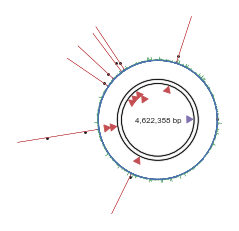

In [30]:
# plot diagram of expected Cas9 nickase sites with a circularized plot of read coverage

# convert Cartesian x,y coordinates of genome locus and read coverage to polar r,theta coordinates
r = 2.85 + (4 * np.concatenate([genomeCov, [genomeCov[0]]]) / max(genomeCov))
theta = math.pi * (0.5 - (2 * np.array(list(range(len(genomeCov))) + [0]) / len(genomeCov)))

def plotLineAroundCircle(start, end, color = blue, lw = 0.4):
    #Plot a single line representing read coverage for all values between the start and end loci
    plt.plot(r[start:end] * np.cos(theta[start:end]), r[start:end] * np.sin(theta[start:end]), color = color, linewidth = lw)

# plot diagram of expected Cas9 nickase sites
plotCircle(len(genomeCov), [calledNicks[i] for i in range(9) if strand[i] == 'top'], [red], [False, False, True], [calledNicks[i] for i in range(9) if strand[i] == 'bottom'], [red, purple, red, red, red, red], [False, False, False, False, False, True], 8)

# plot in green coverage for all MACS2 peaks with high enough quality score that do not contain nicks
for _, peak in peaks[(peaks.logQ >= 0.40433) & (peaks.nicksContained == 0)].iterrows():
    plotLineAroundCircle(peak.start - 1, peak.end + 1, green)

# plot in blue coverage for all loci not contained in a high quality MACS2 peak
start = 0
for _, peak in peaks[peaks.logQ >= 0.40433].iterrows():
    plotLineAroundCircle(start, peak.start)
    start = peak.end
plotLineAroundCircle(start, len(r))

#plot in read coverage for all MACS2 peaks that contain nicks
for _, peak in peaks[peaks.nicksContained > 0].iterrows():
    plotLineAroundCircle(peak.start - 1, peak.end + 1, red)
#plot a black dot at all nick loci
plt.scatter(r[calledNicks] * np.cos(theta[calledNicks]), r[calledNicks] * np.sin(theta[calledNicks]), color = 'k', s = 4)

plt.axis('scaled')
plt.axis('off')

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_5A.pdf', bbox_inches = 'tight', transparent = 'True')

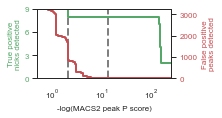

In [31]:
# plot the number of identified nicks and the number of MACS2 peaks that do not contain nicks as a function of MACS2 p value cutoff

pos = []
neg = []
p = []
# temp is a copy of the MACS2 peak data, peaks will be removed from it sequentially based on p value
temp = peaks.copy()
while not temp.empty:
    # count number of nicks in current peaks
    numNicks = sum(temp.nicksContained)
    pos.append(numNicks)
    # count number of current peaks that do not contain nicks
    neg.append(len(temp) - numNicks + 1)
    minP = min(temp.logP)
    p.append(minP)
    # remove peaks with the lowest p value
    temp = temp[temp.logP > minP]

fig, ax1 = plt.subplots(figsize = (2.4, 1.28))

# plot dashed line at p value of most significant MACS2 peak without a nick
ax1.axvline(p[neg.index(1)], ls = 'dashed', c = 'gray')
# plot dashed line at p value of least significant MACS2 peak with a nick
ax1.axvline(p[pos.index(8) - 1], ls = 'dashed', c = 'gray')

# plot in green on the left y axis the number of identified nicks as a function of MACS2 p value cutoff
ax1.step(p, pos, c = green)
ax1.set_ylim(0, 9)

# plot in red on the right y axis the number of MACS2 peaks that do not contain nicks as a function of MACS2 p value cutoff
ax2 = ax1.twinx()
ax2.set_ylim([0, max(neg)])
ax2.step(p, neg, c = red)

ax1.set_xscale('log')
ax1.set_xlim([0, max(p)])

ax1.set_xlabel('-log(MACS2 peak P score)')
ax1.set_ylabel('True positive\nnicks detected', color = green)
ax1.tick_params(axis = 'y', labelcolor = green)
ax2.set_ylabel('False positive\npeaks detected', color = red)
ax2.tick_params(axis = 'y', labelcolor = red)
ax1.set_yticks([0, 3, 6, 9])
ax2.set_yticks([0, 1000, 2000, 3000])

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_5B.pdf', bbox_inches = 'tight', transparent = 'True')

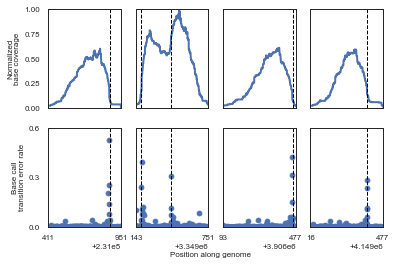

In [32]:
# plot normalized coverage and transition mutation rates for some of the highly enriched nicks in the E. coli data

m = max(genomeCov)

fig, _ = plt.subplots(2, 4, sharex = True, sharey = True, figsize = (6, 4))
        
count = 0
# data will be plotted for nicks 0, 3, 5, and 7 (and 4, since it's in the same MACS2 peak as 3)
# the rest of the relevant data will be plotted in the supplement
for i in [0, 3, 5, 7]:
    count += 1
    # identify peak that contains the relevant nick
    peak = peaks[(peaks.start < calledNicks[i]) & (peaks.end > calledNicks[i])].iloc[0]
    plt.subplot(2, 4, count)
    plt.xticks([])
    plt.ylim((0, 1))
    plt.xlim([peak.start, peak.end + 1])
    # normalize coverage data to be between 0 and 1, then plot
    plt.plot(range(peak.start, peak.end + 1), genomeCov[peak.start:peak.end + 1] / m)
    if i == 0:
        plt.ylabel('Normalized\nbase coverage')
        plt.yticks([0, 0.25, 0.5, 0.75, 1])
    else:
        plt.yticks([])
    # plot black dashed line at the nick
    plt.axvline(calledNicks[i], ls = 'dashed', color = 'black', lw = 1)
    # if this is called nick 3, it is in the same MACS2 peak as called nick 4
    # so put a black dashed line at that nick as well
    if i == 3:
        plt.axvline(calledNicks[i + 1], ls = 'dashed', color = 'black', lw = 1)

    plt.subplot(2, 4, count + 4)
    plt.xlim([peak.start, peak.end + 1])
    plt.ylim([0, 0.6])
    plt.xticks([peak.start, peak.end], horizontalalignment = 'center')
    # calculate transition mutation rates, then plot
    transition = baseTransitions(genomeReference[peak.start:peak.end + 1])
    plt.scatter(range(peak.start, peak.end + 1), [genomeBases[i + peak.start][transition[i]] for i in range(len(transition))], s = 24)
    if i == 0:
        plt.ylabel('Base call\ntransition error rate')
        plt.yticks([0, 0.3, 0.6])
        plt.gca().get_xaxis().get_major_formatter().set_useOffset(231000)
    else:
        plt.yticks([])
    # plot black dashed line at the nick
    plt.axvline(calledNicks[i], ls = 'dashed', color = 'black', lw = 1)
    # if this is called nick 3, it is in the same MACS2 peak as called nick 4
    # so put a black dashed line at that nick as well
    if i == 3:
        plt.axvline(calledNicks[i + 1], ls = 'dashed', color = 'black', lw = 1)

fig.text(0.5, 0.04, '\nPosition along genome', va = 'center', ha = 'center', fontsize = 8)

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_5C.pdf', bbox_inches = 'tight', transparent = 'True')

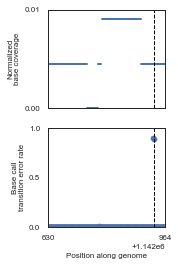

In [33]:
# plot normalized coverage and transition mutation rate for the lowly enriched nick in the E. coli data

m = max(genomeCov)

plt.figure(figsize = (2.1, 4))

i = calledNicks[1]
peak = peaks[(peaks.start < i) & (peaks.end > i)].iloc[0]

plt.subplot(2, 1, 1)
plt.xticks([])
plt.ylim((0, 0.01))
plt.xlim([peak.start, peak.end + 1])
# normalize coverage data to be between 0 and 1, then plot
toPlot = genomeCov[peak.start:peak.end + 1] / m
jumps = np.where(toPlot[1:] != toPlot[:-1])[0]
plt.plot([peak.start, peak.start + jumps[0]], [toPlot[0], toPlot[jumps[0]]], c = blue)
for j in range(1, len(jumps)):
    plt.plot([peak.start + jumps[j - 1] + 1, peak.start + jumps[j]], [toPlot[jumps[j - 1] + 1], toPlot[jumps[j]]], c = blue)
plt.ylabel('Normalized\nbase coverage')
plt.yticks([0, 0.01])
# plot black dashed line at the nick
plt.axvline(i, ls = 'dashed', color = 'black', lw = 1)

plt.subplot(2, 1, 2)
plt.xlim([peak.start, peak.end + 1])
plt.ylim([0, 1])
plt.xticks([peak.start, peak.end], horizontalalignment = 'center')
# calculate transition mutation rates, then plot
transition = baseTransitions(genomeReference[peak.start:peak.end + 1])
toPlot = np.array([genomeBases[i + peak.start][transition[i]] for i in range(len(transition))])
nan = np.isnan(toPlot)
toPlot[nan] = 0
plt.scatter(range(peak.start, peak.end + 1), toPlot, s = 24)
plt.ylabel('Base call\ntransition error rate')
plt.xlabel('\nPosition along genome')
plt.yticks([0, 0.5, 1])
plt.gca().get_xaxis().get_major_formatter().set_useOffset(1142000)
# plot black dashed line at the nick
plt.axvline(i, ls = 'dashed', color = 'black', lw = 1)
            
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_5D.pdf', bbox_inches = 'tight', transparent = 'True')

### Figure 6

In [34]:
def hg19CountCoverage(chromosome, peakData, dist = 5000, keep = 0):
    #Return coverage for human genomic DNA data in the area around a specific MACS2 peak
    peak = [int(peakData.start) - 1, int(peakData.end)]
    dist = min(dist, peak[0])
    cov = np.array([0] * (peak[1] - peak[0] + 2 * dist))
    count = 0
    # loop through all reads that are within a certain range of the MACS2 peak
    for read in samfileCoverage.fetch(chromosome, peak[0] - dist, peak[1] + dist):
        if read.is_proper_pair:
            start = read.reference_start
            stop = read.reference_end
            # count number of reads that are actually within the MACS2 peak bounds
            if start < int(peakData.end) and stop > int(peakData.start):
                count += 1
            mateStart = read.next_reference_start
            # infer full length of read from paired end alignments
            if start > mateStart or (start == mateStart and read.mate_is_reverse):
                cov[mateStart - peak[0] + dist:stop - peak[0] + dist] += 1
    # dist and keep determine how many base pairs extended from the MACS2 peak bounds are included in the returned data
    if dist == 0:
        start = 0
        end = 0
    else:
        # if the first datapoint returned does not have coverage of zero, the return range is extended earlier so as to not cut off reads
        start = np.where(cov[:dist] == 0)[0]
        if len(start) == 0:
                start = 0
        else:
            start = max(start[-1] - dist - 1, 0)
        # if the last datapoint returned does not have coverage of zero, the return range is extended later so as to not cut off reads
        end = np.where(cov[len(cov) - dist:] == 0)[0]
        if len(end) == 0:
            end = dist - keep
        else:
            end = end[0]
    # set index for dataframe to the genomic loci, then return it
    return pd.DataFrame(data = cov[dist + start - keep:len(cov) - dist + end + keep], index = range(int(peakData.start) + start - keep, int(peakData.end) + end + 1 + keep)), count / 2

def hg19CountBases(chromosome, peak, qThreshold = 30):
    #Return fraction of each base that is called at each position for human genomic DNA in a specific MACS2 peak
    
    # read all relevant base calls above the quality threshold
    c = samfileBases.count_coverage(chromosome, peak[0] - 1, peak[1], quality_threshold = qThreshold)    
    # convert base calls to a dataframe indexed by base letter instead of number (e.g. A instead of 0)
    cov = pd.DataFrame()
    for i in index:
        cov = pd.concat([cov, pd.DataFrame(c[i].tolist()).T])
    cov.index = index2
    cov.columns = range(peak[0], peak[1] + 1)
    return cov

def hg19CalculatePK(chromosome, bases):
    #Return transition mutation rate for human genomic DNA given a set of basecalls
    pk = pd.DataFrame(data = [0] * bases.shape[1], index = bases.columns)
    # sum values in each column of bases to get total number of reads at each locus
    s = bases.sum(0)
    for i in bases.columns:
        if s[i] != 0:
            # determine expected base at this locus from the genome reference
            temp = hg19[chromosome][i - 1]
            # given the genome reference, determine rate of the transition base (e.g. A -> G) in the data
            if temp == 'A':
                pk.loc[i] = bases[i]['G'] / s[i]
            elif temp == 'G':
                pk.loc[i] = bases[i]['A'] / s[i]
            elif temp == 'C':
                pk.loc[i] = bases[i]['T'] / s[i]
            elif temp == 'T':
                pk.loc[i] = bases[i]['C'] / s[i]
    return pk

In [35]:
# initialize reading of data files
samfileBases = pysam.AlignmentFile(data_dir + 'fig6/NickSeq_hg19.highMapQ.bam')
samfileCoverage = pysam.AlignmentFile(data_dir + 'fig6/NickSeq_hg19.highMapQ.rmdup.bam')

# read in genome reference
hg19 = readReference(data_dir + '../../../Reference Sequences/Human/hg19')
temp = list(hg19['chr19'])
# locus appears to have a mutation after sequencing it
temp[55627222] = 'T'
hg19['chr19'] = ''.join(temp)
aavs1 = 'GGGGCCACTAGGGACAGGAT'

# call MACS2 on dataset (if needed, can also be done beforehand in Terminal) and load the called peaks
#os.system('macs2 callpeak -t ' + data_dir + 'fig6/NickSeq_hg19.highMapQ.bam -f BAMPE -q 0.95 -g hs -n ' + data_dir + 'fig6/NickSeq_hg19')
hgPeaks = loadPeaks(data_dir + 'fig6/NickSeq_hg19_peaks.xls', 24)

# load ENCODE blacklist regions
blackList = dict()
with open(data_dir + '../../../Reference Sequences/Human/blacklists/hg19-blacklist_allCombined.csv') as textfile:
    for row in textfile:
        temp = row.strip().split(',')
        if temp[0] in blackList:
            blackList[temp[0]].append([int(temp[1]), int(temp[2])])
        else:
            blackList[temp[0]] = [[int(temp[1]), int(temp[2])]]

# loop through all blacklist regions and mark all MACS2 peaks that overlap one of the blacklisted regions
hgPeaks['blackList'] = False
for i in blackList:
    for j in blackList[i]:
        hgPeaks.loc[(hgPeaks.chromosome == i) & (hgPeaks.start <= j[1]) & (hgPeaks.end >= j[0]), 'blackList'] = True

# print total number of MACS2 peaks
print(str(len(hgPeaks)) + ' MACS2 peaks')
# print number of MACS2 peaks that don't intersect a blacklist region
print(str(len(hgPeaks[hgPeaks.blackList == False])) + ' MACS2 peaks not black listed')
# print number of MACS2 peaks that aren't blacklisted and have a sufficient quality score
# with hg38, use 'hgPeaks.logQ > 0.6' instead
print(str(len(hgPeaks[(hgPeaks.blackList == False) & (hgPeaks.logQ > 0.4)])) + ' MACS2 peaks not black listed, with good enough quality score')

peaksWithAnyPK = 0
peaksWithNick = []
# loop through MACS2 peaks to identify nicks
# with hg38, use 'hgPeaks.logQ > 0.6' instead
for i, row in hgPeaks[(hgPeaks.blackList == False) & (hgPeaks.logQ > 0.4)].sort_values('logQ', ascending = False).iterrows():
    # load coverage, base call, and transition mutation data for the current MACS2 peak
    cov, count = hg19CountCoverage(row.chromosome, row)
    bases = hg19CountBases(row.chromosome, [cov.index[0], cov.index[-1]])
    pk = hg19CalculatePK(row.chromosome, bases)
    
    # identify maximum transition mutation rate in this MACS2 peak
    maxMut = 0
    # genome reference is soft masked (locations identified by RepeatMasker and Tandem Repeats Finder are lowercase)
    if not hg19[row.chromosome][row.start:row.end + 1].islower():
        # get highest transition mutation rate that is not in or directly next to a soft masked sequence
        # boolList tracks which loci in this MACS2 peak are to be ignored due to masking
        boolList = [j.isupper() for j in hg19[row.chromosome][cov.index[0]:cov.index[-1] + 1]]
        boolListCopy = boolList.copy()
        for j in range(1, len(boolList) - 1):
            if not (boolListCopy[j - 1] and boolListCopy[j + 1]):
                boolList[j] = False
        for j in [0, 1, 2]:
            boolList[j] = False
            boolList[-1 - j] = False
        # if any mutation rates are determined to be 1, they are set to 0
        # these may be the result of mutations in the actual DNA sample compared to the reference genome
        # observed mutations from dPTP/dKTP are expected to not be fully penetrant
        for j in pk.index:
            if pk.loc[j, 0] == 1:
                pk.loc[j, 0] = 0
        if any(boolList):
            maxMut = max(pk.values[boolList, 0])
    
    # exclude this MACS2 peak from further analysis if it contains too many reads or very little mutational signal
    # count variable represents number of sequencing reads in the MACS2 peak, values over 100 are expected to be due to improper mapping (e.g. at chrUn_gl000220:117743-144606)
    if count < 100 and maxMut > 0.1:
        peaksWithAnyPK += 1
        # get a list of all sites in this MACS2 peak with significant mutation rate
        n = np.where((pk.values[:, 0] > 0.1) & boolList)[0]
        # check if there are multiple sites with mutation rate in close proximity to one another
        if len(n) > 1 and min(n[1:] - n[:-1]) < 5:
            ind = pk.index[n[np.where(n[1:] - n[:-1] == min(n[1:] - n[:-1]))[0][0]]]
            flag = True
            for j in range(-2, 3):
                # this checks to make sure the reference genome at the nick site isn't a long repeat of a single nucleotide
                # in both directions, the first location of a different nucleotide is searched for and if it is too far away the nick site is ignored
                if 100 - np.where(np.array(list(hg19[row.chromosome][ind - j - 100:ind - j])) != hg19[row.chromosome][ind - j])[0][-1] + np.where(np.array(list(hg19[row.chromosome][ind - j + 1:ind - j + 101])) != hg19[row.chromosome][ind - j])[0][0] >= 10:
                    flag = False
                    break
            # check if there is a minimum number of base calls at the nick site
            if flag and sum(bases[ind]) >= 5:
                for j in range(-3, 4):
                    # this checks to make sure the base calls at the suspected nick locus are relatively consistent (discounting dPTP/dKTP signal)
                    # if there isn't signal from dPTP/dKTP or consistency in base calls this could be improper mapping, and not an actual nick
                    # for example 0.25 of all base calls at the locus being each of the four nucleotides will fail this check
                    if max(bases.loc[:, ind + j] / sum(bases.loc[:, ind + j])) + pk.loc[ind + j, 0] < 0.65:
                        flag = False
                        break
                if flag:
                    peaksWithNick.append(i)

# print number of MACS2 peaks with mutational signal and number of final nicks identified
print(str(peaksWithAnyPK) + ' of these peaks contain any mutational signal')
print(str(len(peaksWithNick)) + ' of these peaks contain mutational signal at near-consecutive locations\n')

# determine nick strandedness and print data on each identified nick
# also save the data for two of the nicks for plotting later
toPlot = []
for i, row in hgPeaks.loc[peaksWithNick].iterrows():
    # re-load coverage, base call, and transition mutation data for the nick-containing MACS2 peaks
    cov, count = hg19CountCoverage(row.chromosome, row)
    bases = hg19CountBases(row.chromosome, [cov.index[0], cov.index[-1]])
    pk = hg19CalculatePK(row.chromosome, bases)
    
    # get nick locus from transition mutation values
    n = np.where((pk.values[:, 0] > 0.1))[0]
    n2 = np.where(n[1:] - n[:-1] < 5)[0]
    loc = [n[n2[0]], n[max(n2) + 1]]
    
    # nick is 5' of enrichment peak, this is a reference strand nick
    if loc[0] < np.argmax(cov.values):
        loc = loc[0] + cov.index[0]
        strand = 'top'
        # get Cas9 nickase target sequence at the nick locus
        seq = reverseComplement(hg19[row.chromosome][loc - 7:loc + 16])
    # nick is 3' of enrichment peak, this is a non-reference strand nick
    else:
        loc = loc[1] + cov.index[0]
        strand = 'bottom'
        # get Cas9 nickase target sequence at the nick locus
        seq = hg19[row.chromosome][loc - 17:loc + 6]
    
    # if the MACS2 peak dataframe index is one of these two values, save the data for plotting
    # 9466 is the on-target site at Chr19:55627123, 17625 is the off-target site at Chr6:36765480
    if i == 9466 or i == 17625:
        toPlot.append([row, loc, strand])
    
    # print nick locus and strand
    print('Nick at chromosome ' + row.chromosome[3:] + ', locus ' + str(loc) + ', ' + strand + ' strand.', end = '\t\t')
    # print complementarity to guide RNA and PAM sequence
    print(str(hammingDistance(seq, aavs1 + 'NGG')) + ' mismatches to the guide RNA, N' + seq[-2:] + ' PAM.')

22258 MACS2 peaks
22089 MACS2 peaks not black listed
1696 MACS2 peaks not black listed, with good enough quality score
146 of these peaks contain any mutational signal
6 of these peaks contain mutational signal at near-consecutive locations

Nick at chromosome 19, locus 55627123, top strand.		0 mismatches to the guide RNA, NGG PAM.
Nick at chromosome 11, locus 61111253, bottom strand.		4 mismatches to the guide RNA, NGG PAM.
Nick at chromosome 6, locus 36765480, bottom strand.		3 mismatches to the guide RNA, NGG PAM.
Nick at chromosome 1, locus 2836457, top strand.		4 mismatches to the guide RNA, NGG PAM.
Nick at chromosome 20, locus 31034836, top strand.		3 mismatches to the guide RNA, NGG PAM.
Nick at chromosome 12, locus 108581682, top strand.		3 mismatches to the guide RNA, NGG PAM.


In [36]:
def hgPlot(row, target, strand, title):
    #Plot normalized coverage and transition mutation rate for a select MACS2 peak in the human genome data
    
    # re-load coverage, base call, and transition mutation data for the nick-containing MACS2 peaks
    cov, _ = hg19CountCoverage(row.chromosome, row, keep = 2000)
    bases = hg19CountBases(row.chromosome, [cov.index[0], cov.index[-1]])
    pk = hg19CalculatePK(row.chromosome, bases)
    
    fig = plt.figure(figsize = (2.25, 4.5))

    ax = fig.add_subplot(plt.GridSpec(3, 1, hspace = 0.18)[0])
    # plot coverage
    toPlot = np.array(cov)
    jumps = np.where(toPlot[1:] != toPlot[:-1])[0]
    ax.plot([cov.index[0], cov.index[0] + jumps[0]], [toPlot[0], toPlot[jumps[0]]], lw = 3.5)
    for i in range(1, len(jumps)):
        ax.plot([cov.index[0] + jumps[i - 1] + 1, cov.index[0] + jumps[i]], [toPlot[jumps[i - 1] + 1], toPlot[jumps[i]]], lw = 3.5, c = blue)
    ax.set_xlim(row.start - 1650, row.end + 1650)
    ax.set_ylim(0, 11)
    # put gray dashed lines at the MACS2 peak boundaries
    ax.axvline(row.start - 50, c = 'gray', ls = 'dashed', lw = 1)
    ax.axvline(row.end + 50, c = 'gray', ls = 'dashed', lw = 1)
    # put a black dashed line at the nick site
    ax.axvline(target, c = 'black', ls = 'dashed', lw = 1)
    ax.set_xticks([row.start - 1650, row.end + 1650])
    ax.set_ylabel('De-duplicated coverage')
    ax.set_yticks(range(0, 12, 2))
    ax.set_title(title)
    plt.gca().get_xaxis().get_major_formatter().set_useOffset(math.floor(cov.index[0] / 10000) * 10000)
    
    ax = fig.add_subplot(plt.GridSpec(3, 1, hspace = 0.18)[1])
    # plot transition mutation signal
    toPlot = pk
    jumps = np.where([toPlot.loc[i] != toPlot.loc[i - 1] for i in toPlot.index[1:]])[0]
    ax.plot([toPlot.index[0], toPlot.index[0] + jumps[0]], [toPlot.iloc[0], toPlot.iloc[jumps[0]]], lw = 3.5)
    for i in range(1, len(jumps)):
        ax.plot([toPlot.index[0] + jumps[i - 1] + 1, toPlot.index[0] + jumps[i]], [toPlot.iloc[jumps[i - 1] + 1], toPlot.iloc[jumps[i]]], lw = 3.5, c = blue)
    solo = jumps[1:][jumps[1:] == jumps[:-1] + 1]
    ax.scatter(toPlot.index[solo], toPlot.iloc[solo], s = 12.5)
    ax.set_ylim(0, 1.1)
    ax.set_xlim(row.start - 50, row.end + 50)
    ax.set_xticks([row.start - 50, row.end + 50])
    ax.set_yticks([0, 0.5, 1])
    # put a black dashed line at the nick site
    ax.axvline(target, c = 'black', ls = 'dashed', lw = 1)
    ax.set_xlabel('Position along Chromosome ' + row.chromosome[3:])
    ax.set_ylabel('Base call\ntransition error rate')
    plt.gca().get_xaxis().get_major_formatter().set_useOffset(math.floor(cov.index[0] / 10000) * 10000)
    
    ax = fig.add_subplot(plt.GridSpec(3, 1, hspace = 0.5)[2])
    sns.despine(ax = ax)
    ax.set_ylim([0, 1.05])
    flag = True
    # get guide RNA target sequence based on if this is a reference or non-reference strand nick
    if strand == 'top':
        r = range(target - 6, target + 17)
        r2 = 6
        seq = hg19[row.chromosome][target - 7:target + 16]
    else:
        r = range(target - 16, target + 7)
        r2 = 16
        seq = hg19[row.chromosome][target - 17:target + 6]
    # plot base call frequency (similar to Fig. 2) for all locations within the guide RNA target sequence
    for l in r:
        if l in bases.columns:
            ini = bases[l] / sum(bases[l])
            p1 = ax.bar(l - target + r2, ini.loc['A'], color = blue, edgecolor = blue, label = 'A')
            p2 = ax.bar(l - target + r2, ini.loc['C'], bottom = ini.loc['A'], color = green, edgecolor = green, label = 'C')
            p3 = ax.bar(l - target + r2, ini.loc['T'], bottom = ini.loc['A'] + ini.loc['C'], color = red, edgecolor = red, label = 'T')
            p4 = ax.bar(l - target + r2, ini.loc['G'], bottom = ini.loc['A'] + ini.loc['C'] + ini.loc['T'], color = purple, edgecolor = purple, label='G')
            if flag:
                ax.legend(loc = "upper left", bbox_to_anchor = (1, 1))
                flag = False
    ax.set_xlim(-0.7, 22.65)
    ax.set_ylabel('Fraction of reads')
    ax.set_yticks([0, 0.5, 1])
    plt.xticks(range(23), [i for i in seq])
    count = 0
    # label the x-axis with guide RNA target sequence, PAM in green and mismatches to the guide RNA in red
    for label in ax.get_xticklabels():
        if (strand == 'top' and count < 3) or (strand == 'bottom' and count >= 20):
            label.set_color(green)
        elif (strand == 'top' and reverseComplement(seq[count]) == aavs1[2 - count]) or (strand == 'bottom' and seq[count] == aavs1[count]):
            label.set_color(blue)
        else:
            label.set_color(red)
        count += 1

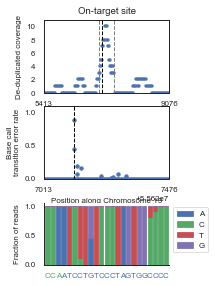

In [37]:
# plot the AAVS1 on-target nick
hgPlot(toPlot[0][0], toPlot[0][1], toPlot[0][2], 'On-target site')
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_6A.pdf', bbox_inches = 'tight', transparent = 'True')

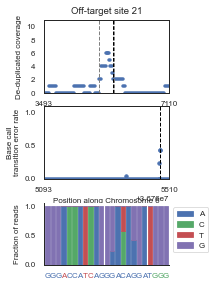

In [38]:
# plot one of the AAVS1 off-target nicks
hgPlot(toPlot[1][0], toPlot[1][1], toPlot[1][2], 'Off-target site 21')
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_6B.pdf', bbox_inches = 'tight', transparent = 'True')

In [39]:
# search for off-targets only at locations with homology to the guide RNA with the help of Cas-OFFinder
potentialOfftargets = dict()
potentialOfftargets['chromosome'] = []
potentialOfftargets['locus'] = []
potentialOfftargets['strand'] = []
potentialOfftargets['mismatches'] = []
potentialOfftargets['bulgeDNA'] = []
potentialOfftargets['bulgeRNA'] = []
# load potential off-targets that have up to 8 mismatches to the guide RNA and no DNA/RNA bulge
with open(data_dir + 'fig6/aavs1CasOFFinder_hg19.txt') as textfile:
    for row in textfile:
        text = row.split('\t')
        potentialOfftargets['chromosome'].append(text[1])
        potentialOfftargets['strand'].append(text[4] == '-')
        if potentialOfftargets['strand'][-1]:
            potentialOfftargets['locus'].append(int(text[2]) + 6)
        else:
            potentialOfftargets['locus'].append(int(text[2]) + 16)
        potentialOfftargets['mismatches'].append(int(text[5][0]))
        potentialOfftargets['bulgeDNA'].append(0)
        potentialOfftargets['bulgeRNA'].append(0)
# load potential off-targets with up to 2 mismatches from the guide RNA and could have a 2 base DNA or RNA bulge
with open(data_dir + 'fig6/aavs1CasOFFinder_hg19_bulge.txt') as textfile:
    next(textfile)
    for row in textfile:
        text = row.split('\t')
        # skip lines with no bulge (they will be duplicates of lines from the no bulge file)
        if text[0] == 'X':
            continue
        # read a line that has a DNA bulge
        elif text[0] == 'DNA':
            potentialOfftargets['strand'].append(text[5] == '-')
            if potentialOfftargets['strand'][-1]:
                potentialOfftargets['locus'].append(int(text[4]) + 6 + text[1].count('-', len(text[1]) - 6))
            else:
                potentialOfftargets['locus'].append(int(text[4]) + 16 + text[1].count('-', 0, len(text[1]) - 6))
            potentialOfftargets['bulgeDNA'].append(int(text[7][0]))
            potentialOfftargets['bulgeRNA'].append(0)
        # read a line that has an RNA bulge
        else:
            potentialOfftargets['bulgeDNA'].append(0)
            potentialOfftargets['bulgeRNA'].append(int(text[7][0]))
            potentialOfftargets['strand'].append(text[5] == '-')
            if potentialOfftargets['strand'][-1]:
                potentialOfftargets['locus'].append(int(text[4]) + 6)
            else:
                potentialOfftargets['locus'].append(int(text[4]) + 16)
        potentialOfftargets['chromosome'].append(text[3])
        potentialOfftargets['mismatches'].append(int(text[6]))
potentialOfftargets = pd.DataFrame(potentialOfftargets)[['chromosome', 'locus', 'strand', 'mismatches', 'bulgeDNA', 'bulgeRNA']]

In [40]:
potentialOfftargets['mutation'] = float('nan')
potentialOfftargets['mutation2'] = float('nan')
# loop through all proposed Cas-OFFinder sites
for i in potentialOfftargets.index:
    # read the base calls and reference sequence of 5 positions just downstream of the potential off-target
    if potentialOfftargets.loc[i, 'strand']:
        bases = np.asarray(samfileBases.count_coverage(potentialOfftargets.loc[i, 'chromosome'], potentialOfftargets.loc[i, 'locus'], potentialOfftargets.loc[i, 'locus'] + 5, quality_threshold = 30))
        ref = hg19[potentialOfftargets.loc[i, 'chromosome']][potentialOfftargets.loc[i, 'locus']:potentialOfftargets.loc[i, 'locus'] + 5].upper()
    else:
        bases = np.asarray(samfileBases.count_coverage(potentialOfftargets.loc[i, 'chromosome'], potentialOfftargets.loc[i, 'locus'] - 4, potentialOfftargets.loc[i, 'locus'] + 1, quality_threshold = 30))
        ref = hg19[potentialOfftargets.loc[i, 'chromosome']][potentialOfftargets.loc[i, 'locus'] - 4:potentialOfftargets.loc[i, 'locus'] + 1].upper()
    # get transition mutation rates from the base calls and reference sequence
    bases = bases / sum(bases, 0)
    m = []
    for j in range(bases.shape[1]):
        if ref[j] == 'A':
            m.append(bases[2, j])
        elif ref[j] == 'C':
            m.append(bases[3, j])
        elif ref[j] == 'G':
            m.append(bases[0, j])
        elif ref[j] == 'T':
            m.append(bases[1, j])
    # save the maximum transition mutation rate observed
    temp = np.nanmax(m)
    potentialOfftargets.loc[i, 'mutation'] = temp
    # if the maximum transition mutation rate is high
    if temp > 0.1:
        # save the second highest transition mutation rate
        m.sort()
        m = [j for j in m if not np.isnan(j)]
        if len(m) > 2:
            potentialOfftargets.loc[i, 'mutation2'] = m[-2]
samfileCoverage.close()
samfileBases.close()

In [41]:
# make nick calls at sites where there are at least 2 of the observed bases have high transition mutation signal
# this ignores sites where 2 bases had a transition rate of 1, in case they're mutations and not dPTP/dKTP signal
hits = potentialOfftargets[(potentialOfftargets.mutation2 >= 0.1) & (potentialOfftargets.mutation2 < 1)].copy()

# remove duplicate hits that arise because Cas-OFFinder allows for DNA/RNA bulges
# for example, the on target site comes up as having zero mismatches
# and as having mismatches and a DNA bulge at the 5' end of the guide RNA
hits['duplicate'] = False
for i, row in hits.iterrows():
    if not row.duplicate:
        # check for duplicates as hits on the same chromosome and within 2 nucleotides of one another
        temp = hits[(hits.chromosome == row.chromosome) & (abs(hits.locus - row.locus) <= 2)]
        if len(temp) > 1:
            # mark duplicate hits
            hits.loc[temp.index, 'duplicate'] = True
            # mark the hit without a bulge, if present, as the true guide RNA target
            if any(temp.bulgeDNA + temp.bulgeRNA == 0):
                hits.loc[temp[temp.bulgeDNA + temp.bulgeRNA == 0].index, 'duplicate'] = False
            else:
                hits.loc[temp.iloc[0].name, 'duplicate'] = False
hits = hits.drop(index = hits[hits.duplicate].index)

# identify any MACS2 peaks that encompass the hits
hits['macs2'] = float('nan')
for i, row in hits.iterrows():
    temp = hgPeaks[(hgPeaks.chromosome == row.chromosome) & (hgPeaks.start - 100 < row.locus) & (hgPeaks.end + 100 > row.locus)]
    if len(temp) > 0:
        hits.loc[i, 'macs2'] = temp.index[0]

def printRow(row, count):
    #Print information on one of the nick calls
    
    # print hit name, either AAVS1 for the on-target or 'Off #'
    if row.mismatches == 0:
        print('AAVS1', end = '\t')
        flag = False
    else:
        print('Off ' + str(count), end = '\t')
        flag = True
    
    # print chromosome and locus
    print(row.chromosome, end = '\t\t')
    print(str(row.locus), end = '\t\t' if row.locus < 10000000 else '\t')
    
    # print strandedness and read guide RNA target sequence from the genome reference
    if row.strand:
        print('+', end = '\t')
        seq = reverseComplement(hg19[row.chromosome][row.locus - 6:row.locus + 17].upper())
    else:
        print('-', end = '\t')
        seq = hg19[row.chromosome][row.locus - 16:row.locus + 7].upper()
        
    # if there's an RNA bulge, dashes are inserted in the target sequence to show this
    if row.bulgeRNA > 0:
        if row.chromosome == 'chr11':
            seq = seq[:-7] + '--' + seq[-7:-2]
        elif row.chromosome == 'chr14':
            seq = seq[:10] + '--' + seq[10:-2]
    
    # print target sequences with mismatches to the guide RNA in red
    for i in range(len(aavs1)):
        if aavs1[i] == seq[i]:
            cprint(seq[i], 'blue', end = '')
        else:
            cprint(seq[i], 'red', end = '')
    print(end = '\t')
    
    # print PAM sequence, if the alternative NAG PAM is observed the A is printed in red
    pam = 'NGG'
    for i in range(3):
        if pam[i] != 'N' and pam[i] != seq[i + 20]:
            cprint(seq[i + 20], 'red', end = '')
        else:
            cprint(seq[i + 20], 'blue', end = '')
    print(end = '\t')
    
    # print MACS2 q score for the peak that encompasses the hit, if applicable
    if np.isnan(row.macs2):
        print('n.a.', end = '\t\t')
    else:
        print(hgPeaks.loc[row.macs2, 'logQ'], end = '\t\t')
    
    # print observed mutation rate
    print(round(row.mutation2, 5))
    
    return flag

count = 1
# print header row
print('Name\tChromosome\tLocus\t\tStrand\tSequence\t\tPAM\t-log(MACS2 q)\tTransition rate')
# print hits in order of chromosome number
for i in range(1, 23):
    # arrange hits on the selected chromosome in order of locus
    temp = hits[hits.chromosome == 'chr' + str(i)].copy()
    temp = temp.sort_values('locus')
    for _, row in temp.iterrows():
        if printRow(row, count):
            count += 1
# print hits on chromosome X last
temp = hits[hits.chromosome == 'chrX'].copy()
for _, row in temp.iterrows():
    if printRow(row, count):
        count += 1

Name	Chromosome	Locus		Strand	Sequence		PAM	-log(MACS2 q)	Transition rate
Off 1	chr1		2836456		+	GGGACCTCCAGGGACAGGAC	GGG	1.50985		0.35
Off 2	chr1		4080070		+	TGGGGCCACAGGGACAGGAC	AGG	0.27097		0.4
Off 3	chr1		20020462	+	GCAATTAACAGGAACAGGAT	TGG	n.a.		0.22222
Off 4	chr1		95200632	-	CAGGGGCACCGGGACAGGAT	GGG	n.a.		0.4
Off 5	chr1		172529245	-	TAGGGGCCCAGAGACAGGAT	GAG	0.07919		0.38462
Off 6	chr1		181190082	+	GGAGCCATGAGGGACAGGAG	GGG	0.27097		0.5
Off 7	chr1		232797742	+	GTGACCACTCAGGACAGGTT	GGG	0.27097		0.25581
Off 8	chr1		239493007	+	GGAGCCCCTAGAAACAGAAT	GAG	n.a.		0.3
Off 9	chr2		138300885	-	TCAGAATCTAAGGACAGGAT	GGG	n.a.		0.6
Off 10	chr3		46313787	+	TGGGGTCCACAGGGCAGGAT	TGG	0.07919		0.33333
Off 11	chr3		148674158	+	CAGGGCTTTAGGGACAGGAT	GAG	n.a.		0.14286
Off 12	chr4		92258747	+	AGAGGAACTAGGAACAGGAT	GAG	n.a.		0.10256
Off 13	chr4		160183199	+	TGGGGAACCAGACACAGGAT	GGG	n.a.		0.63636
Off 14	chr5		16825712	+	CTGGGCACTGGGGACAAGAT	GGG	n.a.		0.66667
Off 15	chr5		92665932	+	TGGTCCATTGTGGAACGGAA	CGG	n.

Off 49	chr20		31034835	+	GGGGCCAGTAGGGGCAGGAC	AGG	1.37413		0.24324
Off 50	chr21		42892947	+	GGGGCCCCTGGGGACAGAAT	GGG	n.a.		0.16667
Off 51	chr22		20781846	-	TGGGCCACTGGGGAAGGATG	AGG	n.a.		0.6875
Off 52	chr22		48542338	-	CTCACCCCTAAGGACAGGAT	GAG	n.a.		0.25
Off 53	chrX		31811312	-	GGTTTTTATAGGCACAGGAT	GGG	n.a.		0.66667


In [42]:
# read in off-targets of wild-type Cas9 identified by Tan et al. 2015
tan = pd.read_excel(data_dir + 'fig6/tan off targets.xlsx', sheet_name = 'human_off-targets')
tan = tan[tan.id == 'AAVS1'].copy()
tan['identified'] = False
# the supplemental file only included whether a potential off-target had PCR primers made for it
# actual hits are hard coded in here, they can be found printed in one of the paper's tables
tan.loc[(tan.chr == 19) & (tan.start == 55627117), 'identified'] = True
tan.loc[(tan.chr == 6) & (tan.start == 36765464), 'identified'] = True
tan.loc[(tan.chr == 13) & (tan.start == 106612912), 'identified'] = True
tan.loc[(tan.chr == 19) & (tan.start == 16174987), 'identified'] = True
tan.loc[(tan.chr == 19) & (tan.start == 45650858), 'identified'] = True
tan.loc[(tan.chr == 21) & (tan.start == 42892942), 'identified'] = True

# read in off-targets of wild-type Cas9 identified by Wang et al. 2014
# numbers are hard coded here since there was no supplemental file containing them
# numbers can be found printed in a supplemental figure of their paper though
wang = dict()
wang['chromosome'] = ['chr' + str(i) for i in [19, 19, 8, 21, 2, 22, 8, 13, 15, 12, 11, 2, 20, 20]]
wang['start'] = [55627117, 16174987, 22635581, 42892942, 232824540, 44699098, 144885120, 37196607, 45827893, 108581676, 47446589, 60390559, 42338563, 31034830]
wang['end'] = [55627139, 16175009, 22635603, 42892964, 232824562, 44699120, 144885142, 37196629, 45827915, 108581698, 47446611, 60390581, 42338585, 31034852]
wang['identified'] = [True, True, True, True, True, True, True, True, False, False, False, False, False, False]
wang = pd.DataFrame(wang)

def xlsxRow(worksheet, row, count, count2, b, r):
    #Print information on a nick call to the specified row of an Excel spreadsheet
    
    # print hit name, either AAVS1 for the on-target or 'Off #'
    if row.mismatches == 0:
        worksheet.write(count2, 0, 'AAVS1')
        flag = False
    else:
        worksheet.write(count2, 0, 'Off ' + str(count))
        flag = True
    
    # print chromosome and locus
    worksheet.write(count2, 1, row.chromosome)
    worksheet.write(count2, 2, str(row.locus))
    
    # print strandedness and read guide RNA target sequence from the genome reference
    if row.strand:
        worksheet.write(count2, 3, '+')
        seq = reverseComplement(hg19[row.chromosome][row.locus - 6:row.locus + 17].upper())
    else:
        worksheet.write(count2, 3, '-')
        seq = hg19[row.chromosome][row.locus - 16:row.locus + 7].upper()
    
    # if there's an RNA bulge, dashes are inserted in the target sequence to show this
    if row.bulgeRNA > 0:
        if row.chromosome == 'chr11':
            seq = seq[:-7] + '--' + seq[-7:-2]
        elif row.chromosome == 'chr14':
            seq = seq[:10] + '--' + seq[10:-2]
    
    # print target sequences with mismatches to the guide RNA in red
    f = []
    for i in range(len(aavs1)):
        if aavs1[i] == 'N' or aavs1[i] == seq[i]:
            f.append(b)
        else:
            f.append(r)
    worksheet.write_rich_string(count2, 4, '', f[0], seq[0], f[1], seq[1], f[2], seq[2], f[3], seq[3], f[4], seq[4], f[5], seq[5], f[6], seq[6], f[7], seq[7], f[8], seq[8], f[9], seq[9], f[10], seq[10], f[11], seq[11], f[12], seq[12], f[13], seq[13], f[14], seq[14], f[15], seq[15], f[16], seq[16], f[17], seq[17], f[18], seq[18], f[19], seq[19])
    
    # print PAM sequence, if the alternative NAG PAM is observed the A is printed in red
    pam = 'NGG'
    f = []
    for i in range(3):
        if pam[i] != 'N' and pam[i] != seq[i + 20]:
            f.append(r)
        else:
            f.append(b)
    worksheet.write_rich_string(count2, 5, '', f[0], seq[20], f[1], seq[21], f[2], seq[22])
    
    # print MACS2 q score for the peak that encompasses the hit, if applicable
    if np.isnan(row.macs2):
        worksheet.write_rich_string(count2, 6, '', r, 'n.a.')
    else:
        worksheet.write_rich_string(count2, 6, '', b, str(hgPeaks.loc[row.macs2, 'logQ']))
    
    # print observed mutation rate
    worksheet.write(count2, 7, str(row.mutation2))
    
    # indicate if Tan et al. 2015 identified this off-target or not (or indicate they didn't test for it)
    temp = tan[(pd.Series(['chr' + str(i) for i in tan.chr]) == row.chromosome) & (row.locus < tan.end) & (row.locus > tan.start)]
    if len(temp) == 1 and temp['Primers designed'].iloc[0] == 'Y':
        if temp.identified.iloc[0]:
            worksheet.write_rich_string(count2, 8, '', b, 'Yes')
        else:
            worksheet.write_rich_string(count2, 8, '', r, 'No')
    else:
        worksheet.write(count2, 8, 'n.a.')
    
    # indicate if Wang et al. 2014 identified this off-target or not (or indicate they didn't test for it)
    temp = wang[(wang.chromosome == row.chromosome) & (row.locus < wang.end) & (row.locus > wang.start)]
    if len(temp) == 1:
        if temp.identified.iloc[0]:
            worksheet.write_rich_string(count2, 9, '', b, 'Yes')
        else:
            worksheet.write_rich_string(count2, 9, '', r, 'No')
    else:
        worksheet.write(count2, 9, 'n.a.')
    
    # indicate whether this hit was able to be identified without the help of Cas-OFFinder
    # hits were hard coded in here since there weren't too many
    if row.name in [175271, 420892, 577476, 56544, 357720, 198501]:
        worksheet.write_rich_string(count2, 10, '', b, 'Yes')
    else:
        worksheet.write(count2, 10, 'No')

    return flag

# print an Excel sheet containing information on the nick calls
if printFigures:
    # create new Excel file
    workbook = xlsxwriter.Workbook(figurePrint_dir + 'Table_S4.xlsx')
    worksheet = workbook.add_worksheet()
    b = workbook.add_format({'color': 'blue'})
    r = workbook.add_format({'color': 'red'})

    # write header row
    worksheet.write(0, 0, 'guide RNA sequence: GGGGCCACTAGGGACAGGAT')
    headings = ['Name', 'Chromosome', 'Locus', 'Strand', 'Sequence', 'PAM', '-log(MACS2 q score)', 'Transition rate', 'Identified by Tan et al. (2014)', 'Identified by Wang et al. (2014)', 'Identified without a priori knowledge']
    for i in range(len(headings)):
        worksheet.write(2, i, headings[i])

    count = 1
    count2 = 2
    # print hits in order of chromosome number
    for i in range(1, 23):
        # arrange hits on the selected chromosome in order of locus
        temp = hits[hits.chromosome == 'chr' + str(i)].copy()
        temp = temp.sort_values('locus')
        for _, row in temp.iterrows():
            count2 += 1
            if xlsxRow(worksheet, row, count, count2, b, r):
                count += 1
    # print hits on chromosome X last
    temp = hits[hits.chromosome == 'chrX'].copy()
    for _, row in temp.iterrows():
        count2 += 1
        if xlsxRow(worksheet, row, count, count2, b, r):
            count += 1

    workbook.close()

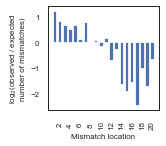

In [43]:
# for all hits without a DNA or RNA bulge, extract guide RNA target sequence
hitSeqs = []
for _, row in hits[hits.bulgeRNA + hits.bulgeDNA == 0].iterrows():
    if row.strand:
        hitSeqs.append(list(reverseComplement(hg19[row.chromosome][row.locus - 6:row.locus + 17].upper())))
    else:
        hitSeqs.append(list(hg19[row.chromosome][row.locus - 16:row.locus + 7].upper()))
hitSeqs = np.array(hitSeqs)

# for all Cas-OFFinder sites without a DNA or RNA bulge, extract guide RNA target sequence
allSeqs = []
for _, row in potentialOfftargets[potentialOfftargets.bulgeRNA + potentialOfftargets.bulgeDNA == 0].iterrows():
    if row.strand:
        allSeqs.append(list(reverseComplement(hg19[row.chromosome][row.locus - 6:row.locus + 17].upper())))
    else:
        allSeqs.append(list(hg19[row.chromosome][row.locus - 16:row.locus + 7].upper()))
allSeqs = np.array(allSeqs)

# for hits and for all Cas-OFFinder sites, count number of times a mismatch occurs at each position in the guide
hitMismatches = np.zeros(20)
allMismatches = np.zeros(20)
for i in range(len(hitMismatches)):
    hitMismatches[i] = sum(hitSeqs[:, i] != aavs1[i])
    allMismatches[i] = sum(allSeqs[:, i] != aavs1[i])
# change mismatch counts into mismatch frequencies by dividing by total number of mismatches
hitMismatches = hitMismatches / sum(hitMismatches)
allMismatches = allMismatches / sum(allMismatches)

fig = plt.figure(figsize = (2, 1.9))

# plot log_2 observed / expected number of mismatches for all locations across the guide RNA
plt.bar(range(1, 21), np.log2(hitMismatches / allMismatches), width = 0.7)

plt.ylabel('log$_2$(observed / expected\nnumber of mismatches)')
plt.xlabel('Mismatch location')
plt.xticks(range(2, 21, 2), rotation = 'vertical', verticalalignment = 'center', horizontalalignment = 'center')
plt.gca().tick_params(axis = 'x', which = 'major', pad = 10)
plt.yticks([-2, -1, 0, 1])

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_6D.pdf', bbox_inches = 'tight', transparent = 'True')

In [44]:
def calculatePPM(sequences):
    #Calculate position probability matrix from a list of sequences
    sequences = np.array([list(i) for i in sequences])

    # calculate position frequency matrix by counting number of times each base occurs at each position
    pfm = np.zeros((23, 4))
    for i in range(pfm.shape[0]):
        for j in range(pfm.shape[1]):
            pfm[i, j] = sum(sequences[:, i] == index2[j])

    # return position frequency matrix divided by the total number of sequences observed
    return pfm / len(sequences)

def bootstrapPPM(dataframe, sort_column, ascending = True):
    #Perform a single bootstrap of a provided sequence list and return the resulting position probability matrix
    
    # choose random sequences from the provided list, with replacement
    bootstrap = dataframe.iloc[np.random.randint(0, len(dataframe), len(dataframe))]
    bootstrapSeqs = bootstrap.sort_values(sort_column, ascending = ascending).iloc[0:52].seq
    
    # return position probability matrix of the randomly selected sequences
    return calculatePPM(bootstrapSeqs)

def plotSequenceLogo(ppm, bootstraps = None, title = ''):
    #Given a position probability matrix, plot the corresponding sequence logo
    
    # determine information content at each location
    ic = np.zeros(23)
    for i in range(ic.shape[0]):
        # information content calculation assumes even distribution of bases across genome
        ic[i] = sum(ppm[i, ppm[i, :] > 0] * np.log2(ppm[i, ppm[i, :] > 0] / 0.25))

    # calculate sequence logo by multiplying position probability matrix by information content
    logo = np.zeros((23, 4))
    for i in range(logo.shape[0]):
        logo[i, :] = ic[i] * ppm[i, :]
    logo = pd.DataFrame(logo, range(1, 24), index2)

    # plot the calculated sequence logo
    logo = logomaker.Logo(logo, font_name = 'Arial', figsize = (5.6, 1.5))
    logo.highlight_position_range(21, 23, alpha = 0.3, color = 'lightgray')
    plt.xticks([])
    plt.yticks([])
    plt.ylim(0, 2)
    sns.despine()
    plt.title(title)
    
    # if bootstrapped position probability matrices are provided, plot error bars
    if not bootstraps is None:
        # determine 5th and 95th percentiles of each letter in the bootstraps for a 90% confidence interval
        errorBars = np.percentile(bootstraps, [5, 95], 0)
        for i in range(4):
            # determine lower bound of error bar
            p5 = errorBars[0, :, i]
            # determine upper bound of error bar
            p95 = errorBars[1, :, i]
            # determine y location of the base the current error bar is being made for
            # this is needed since the sequence logo plots each letter in order of frequency at each position
            # as opposed to the letters at each position always being plotted in the same order
            y = []
            for j in range(23):
                y.append(ic[j] * sum(ppm[j, ppm[j, :] <= ppm[j, i]]))
            # plot error bar
            plt.errorbar(range(1, 24), y, [ic * (ppm[:, i] - p5), ic * (p95 - ppm[:, i])], fmt = 'none', c = 'k', linewidth = 0.5, capsize = 2, capthick = 0.5)

def diffLogoH(ppm1, ppm2):
    #Determine the DiffLogo heights given two position probability matrices
    H = np.zeros(len(ppm1))
    # below is an implementation of equation 3 in the DiffLogo paper
    for i in range(4):
        m = (ppm1[:, i] + ppm2[:, i]) / 2
        h1 = ppm1[:, i] * np.log2(ppm1[:, i] / m)
        h1[np.isnan(h1)] = 0
        h2 = ppm2[:, i] * np.log2(ppm2[:, i] / m)
        h2[np.isnan(h2)] = 0
        H += h1 + h2
    return H / 2

def diffLogoR(ppm1, ppm2):
    #Determine the DiffLogo weights given two position probability matrices
    
    # below is an implementation of equation 5 in the DiffLogo paper
    R = (ppm1 - ppm2) / np.transpose(np.array([np.sum(np.absolute(ppm1 - ppm2), 1)]))
    R[np.isnan(R)] = 0
    return R

def plotDiffLogo(measuredPPM, predictedPPM, bootstraps = None, title = ''):
    #Plot a DiffLogo given two position probaiblity matrices
    
    # calculate logo weights and heights
    r = diffLogoR(measuredPPM, predictedPPM)
    h = diffLogoH(measuredPPM, predictedPPM)

    # calculate the DiffLogo, equation 4 in the DiffLogo paper
    temp = r * np.transpose(np.array([h]))
    logoDiff = pd.DataFrame(temp, range(1, 24), index2)

    # plot the calculated DiffLogo
    logoDiff = logomaker.Logo(logoDiff, font_name = 'Arial', figsize = (5.6, 1.5))
    logoDiff.highlight_position_range(21, 23, alpha = 0.3, color = 'lightgray')
    plt.xticks([])
    plt.yticks([])
    plt.ylim(-0.165, 0.165)
    sns.despine()
    plt.title(title + '\nDifference score: ' + str(round(sum(h), 3)))

    # if bootstrapped position probability matrices are provided, plot error bars
    if not bootstraps is None:
        diffBOOT = []
        # if both the measured and predicted position probability matrices were bootstrapped
        if not bootstraps[0] is None and not bootstraps[1] is None:
            for i, j in zip(bootstraps[0], bootstraps[1]):
                diffBOOT.append(diffLogoR(i, j))
        # if only the predicted position probability matrices were bootstrapped
        elif not bootstraps[0] is None:
            for i in bootstraps[0]:
                diffBOOT.append(diffLogoR(i, predictedPPM))
        # if only the measured position probability matrices were bootstrapped
        elif not bootstraps[1] is None:
            for i in bootstraps[1]:
                diffBOOT.append(diffLogoR(measuredPPM, i))
        
        # determine 5th and 95th percentiles of each letter in the bootstraps for a 90% confidence interval
        errorBars = np.percentile(diffBOOT, [5, 95], 0)
        for i in range(4):
            # determine lower bound of error bar
            p5 = errorBars[0, :, i]
            # determine upper bound of error bar
            p95 = errorBars[1, :, i]
            # determine y location of the base the current error bar is being made for
            # this is needed since the sequence logo plots each letter in order of frequency at each position
            # as opposed to the letters at each position always being plotted in the same order
            y = []
            for j in range(23):
                temp = r[j, i]
                if temp > 0:
                    temp2 = r[j, r[j, :] > 0]
                    y.append(h[j] * sum(temp2[temp2 <= temp]))
                else:
                    temp2 = r[j, r[j, :] < 0]
                    y.append(h[j] * sum(temp2[temp2 >= temp]))
            # plot error bar
            plt.errorbar(range(1, 24), y, [h * (r[:, i] - p5), h * (p95 - r[:, i])], fmt = 'none', c = 'k', linewidth = 0.5, capsize = 2, capthick = 0.5)

In [45]:
# determine position probability matrix for hits and for all Cas-OFFinder sites
ppm = calculatePPM(hitSeqs)
ppmCasOFF = calculatePPM(allSeqs)

# load CCtop off-target predictions
cctop = dict()
cctop['seq'] = []
cctop['rank'] = []
with open(data_dir + 'fig6/CCtop offtarget predictions.xls') as csvfile:
    reader = csv.reader(csvfile)
    for i in range(14):
        next(reader)
    rank = 0
    for row in reader:
        if len(row) > 0:
            text = row[0].split('\t')
            cctop['seq'].append(text[5] + text[6])
            rank += 1
            cctop['rank'].append(rank)
cctop = pd.DataFrame(cctop)
# create CCtop position probability matrix from top 52 predictions
ppmCCTOP = calculatePPM(cctop[cctop['rank'] <= 52]['seq'])

# load CRISPOR off-target predictions
crispor = pd.read_excel(data_dir + 'fig6/crispor offtarget predictions.xls', header = 8)
crispor = crispor[['offtargetSeq', 'mitOfftargetScore', 'cfdOfftargetScore']]
crispor.columns = ['seq', 'mitScore', 'cfdScore']
temp = []
for i in crispor.index:
    if crispor.loc[i, 'seq'][-1] != 'G':
        temp.append(i)
crispor = crispor.drop(temp, axis = 0)
# create CRISPOR position probability matrix from top 52 predictions based on CFD scores
temp = crispor.sort_values('cfdScore', ascending = False).copy()
ppmCFD = calculatePPM(temp.iloc[:52]['seq'])
# create CRISPOR position probability matrix from top 52 predictions based on MIT scores
temp = crispor.sort_values('mitScore', ascending = False).copy()
ppmMIT = calculatePPM(temp.iloc[:52]['seq'])

# load DeepCRISPR off-target predictions
deepcrisp = dict()
deepcrisp['seq'] = []
deepcrisp['score'] = []
with open(data_dir + 'fig6/deepcrispr offtarget predictions hela.txt') as textfile:
    count = 0
    for row in textfile.readlines():
        count += 1
        if count % 3 == 1:
            deepcrisp['seq'].append(row[:-1])
        elif count % 3 == 0:
            deepcrisp['score'].append(float(row[:-1]))
deepcrisp = pd.DataFrame(deepcrisp)
# create DeepCRISPR position probability matrix from top 52 predictions
ppmDEEP = calculatePPM(deepcrisp.iloc[:52]['seq'])

# load CROP-IT off-target predictions
cropit = dict()
cropit['seq'] = []
cropit['score'] = []
cropit['mismatches'] = []
cropit['PAM'] = []
with open(data_dir + 'fig6/CROPit offtarget predictions.txt') as textfile:
    count = 0
    for row in textfile:
        count += 1
        if count > 16:
            text = row.split('\t')
            cropit['seq'].append(text[3].upper())
            cropit['score'].append(float(text[5]))
            cropit['mismatches'].append(int(text[4]))
            cropit['PAM'].append('N' + text[3][-2:].upper())
cropit = pd.DataFrame(cropit)
# remove NTG and NCG PAMs. CROP-IT had option for NGG and NNG but not NRG
cropitRelevant = cropit[(cropit.mismatches <= 8) & ((cropit.PAM == 'NGG') | (cropit.PAM == 'NAG'))].copy()
# create CROP-IT position probability matrix from top 52 predictions
ppmCROPIT = calculatePPM(cropitRelevant.iloc[:52].seq)

In [46]:
def bootstraps(num = 10000):
    #Perform bootstraps for measured and all predicted Cas9 off-target position probability matrices
    hitsBOOT = []
    cctopBOOT = []
    cfdBOOT = []
    mitBOOT = []
    deepBOOT = []
    cropitBOOT = []
    # perform number of bootstraps specified
    for i in range(num):
        # perform bootstraps for the measured off-targets directly here
        hitsBOOT.append(calculatePPM(hitSeqs[np.random.randint(0, len(hitSeqs), len(hitSeqs))]))
        # for the predicted off-targets use the function written above
        cctopBOOT.append(bootstrapPPM(cctop, 'rank'))
        cfdBOOT.append(bootstrapPPM(crispor, 'cfdScore', False))
        mitBOOT.append(bootstrapPPM(crispor, 'mitScore', False))
        deepBOOT.append(bootstrapPPM(deepcrisp, 'score', False))
        cropitBOOT.append(bootstrapPPM(cropitRelevant, 'score', False))
    return np.array(hitsBOOT), np.array(cctopBOOT), np.array(cfdBOOT), np.array(mitBOOT), np.array(deepBOOT), np.array(cropitBOOT)
    
# bootstraps are very time consuming, commented out for convenience
#hitsBOOT, cctopBOOT, cfdBOOT, mitBOOT, deepBOOT, cropitBOOT = bootstraps(5)

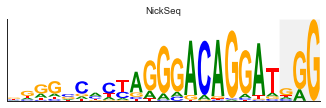

In [47]:
# plot sequence logo for off-targets measured by NickSeq
plotSequenceLogo(ppm, title = 'NickSeq')
#plotSequenceLogo(ppm, hitsBOOT, title = 'NickSeq')
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_6E_nickseq.pdf', bbox_inches = 'tight', transparent = 'True')

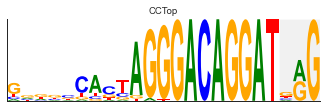

In [48]:
# plot sequence logo for off-targets predicted by CCTop
plotSequenceLogo(ppmCCTOP, title = 'CCTop')
#plotSequenceLogo(ppmCCTOP, cctopBOOT, title = 'CCTop')
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_6E_cctop.pdf', bbox_inches = 'tight', transparent = 'True')

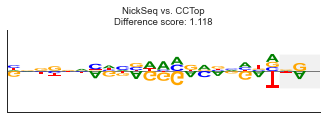

In [49]:
# plot DiffLogo between measured NickSeq sites and CCTop predicted sites
plotDiffLogo(ppm, ppmCCTOP, title = 'NickSeq vs. CCTop')
#plotDiffLogo(ppm, ppmCCTOP, [None, cctopBOOT], 'NickSeq vs. CCTop')
#plotDiffLogo(ppm, ppmCCTOP, [hitsBOOT, None], 'NickSeq vs. CCTop')
#plotDiffLogo(ppm, ppmCCTOP, [hitsBOOT, cctopBOOT], 'NickSeq vs. CCTop')
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_6E_nickseq_cctop.pdf', bbox_inches = 'tight', transparent = 'True')

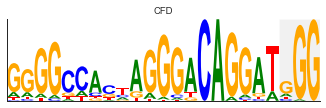

In [50]:
# plot sequence logo for off-targets predicted by CRISPOR with CFD scores
plotSequenceLogo(ppmCFD, title = 'CFD')
#plotSequenceLogo(ppmCFD, cfdBOOT, 'CFD')
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_6E_cfd.pdf', bbox_inches = 'tight', transparent = 'True')

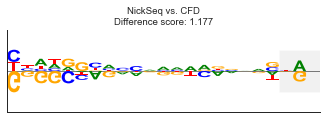

In [51]:
# plot DiffLogo between measured NickSeq sites and CRISPOR CFD predicted sites
plotDiffLogo(ppm, ppmCFD, title = 'NickSeq vs. CFD')
#plotDiffLogo(ppm, ppmCFD, [None, cfdBOOT], 'NickSeq vs. CFD')
#plotDiffLogo(ppm, ppmCFD, [hitsBOOT, None], 'NickSeq vs. CFD')
#plotDiffLogo(ppm, ppmCFD, [hitsBOOT, cfdBOOT], 'NickSeq vs. CFD')
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_6E_nickseq_cfd.pdf', bbox_inches = 'tight', transparent = 'True')

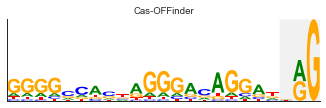

In [52]:
# plot sequence logo for all off-targets proposed by Cas-OFFinder
plotSequenceLogo(ppmCasOFF, title = 'Cas-OFFinder')
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_6E_casoff.pdf', bbox_inches = 'tight', transparent = 'True')

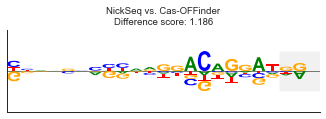

In [53]:
# plot DiffLogo between measured NickSeq sites and all Cas-OFFinder proposed sites
plotDiffLogo(ppm, ppmCasOFF, title = 'NickSeq vs. Cas-OFFinder')
#plotDiffLogo(ppm, ppmCasOFF, [hitsBOOT, None], 'NickSeq vs. Cas-OFFinder')
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_6E_nickseq_casoff.pdf', bbox_inches = 'tight', transparent = 'True')

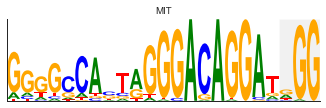

In [54]:
# plot sequence logo for off-targets predicted by CRISPOR with MIT scores
plotSequenceLogo(ppmMIT, title = 'MIT')
#plotSequenceLogo(ppmMIT, mitBOOT, 'MIT')
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_6E_mit.pdf', bbox_inches = 'tight', transparent = 'True')

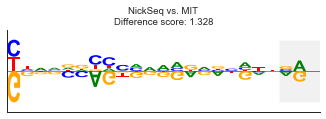

In [55]:
# plot DiffLogo between measured NickSeq sites and CRISPOR MIT predicted sites
plotDiffLogo(ppm, ppmMIT, title = 'NickSeq vs. MIT')
#plotDiffLogo(ppm, ppmMIT, [None, mitBOOT], 'NickSeq vs. MIT')
#plotDiffLogo(ppm, ppmMIT, [hitsBOOT, None], 'NickSeq vs. MIT')
#plotDiffLogo(ppm, ppmMIT, [hitsBOOT, mitBOOT], 'NickSeq vs. MIT')
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_6E_nickseq_mit.pdf', bbox_inches = 'tight', transparent = 'True')

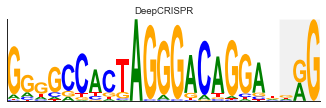

In [56]:
# plot sequence logo for off-targets predicted by DeepCRISPR
plotSequenceLogo(ppmDEEP, title = 'DeepCRISPR')
#plotSequenceLogo(ppmDEEP, deepBOOT, 'DeepCRISPR')
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_6E_deep.pdf', bbox_inches = 'tight', transparent = 'True')

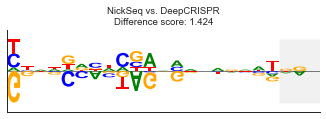

In [57]:
# plot DiffLogo between measured NickSeq sites and DeepCRISPR predicted sites
plotDiffLogo(ppm, ppmDEEP, title = 'NickSeq vs. DeepCRISPR')
#plotDiffLogo(ppm, ppmDEEP, [None, deepBOOT], 'NickSeq vs. DeepCRISPR')
#plotDiffLogo(ppm, ppmDEEP, [hitsBOOT, None], 'NickSeq vs. DeepCRISPR')
#plotDiffLogo(ppm, ppmDEEP, [hitsBOOT, deepBOOT], 'NickSeq vs. DeepCRISPR')
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_6E_nickseq_deep.pdf', bbox_inches = 'tight', transparent = 'True')

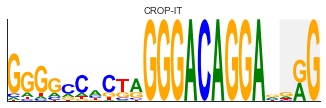

In [58]:
# plot sequence logo for off-targets predicted by CROP-IT
plotSequenceLogo(ppmCROPIT, title = 'CROP-IT')
#plotSequenceLogo(ppmCROPIT, cropitBOOT, 'CROP-IT')
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_6E_cropit.pdf', bbox_inches = 'tight', transparent = 'True')

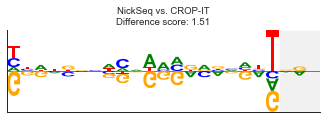

In [59]:
# plot DiffLogo between measured NickSeq sites and CROP-IT predicted sites
plotDiffLogo(ppm, ppmCROPIT, title = 'NickSeq vs. CROP-IT')
#plotDiffLogo(ppm, ppmCROPIT, [None, cropitBOOT], 'NickSeq vs. CROP-IT')
#plotDiffLogo(ppm, ppmCROPIT, [hitsBOOT, None], 'NickSeq vs. CROP-IT')
#plotDiffLogo(ppm, ppmCROPIT, [hitsBOOT, cropitBOOT], 'NickSeq vs. CROP-IT')
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_6E_nickseq_cropit.pdf', bbox_inches = 'tight', transparent = 'True')

### Figure S1

In [34]:
enzymes = ['taq', 'therminator', 'sulfolobusPolIV']
# load data for oligo experiments with dPTP and dKTP
dKTP = countOligoBases([data_dir + 'figS1/oligo_dPTP_dKTP_' + i + 'Extension_R1.fastq.gz' for i in enzymes], 62, 11, True)
# load data for oligo experiments with dPTP and dRTP
dRTP = countOligoBases([data_dir + 'figS1/oligo_dPTP_dRTP_' + i + 'Extension_R1.fastq.gz' for i in enzymes], 62, 11, True)
seq = 'TGAGTCACTTG'

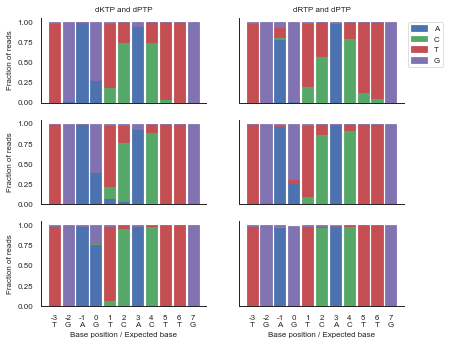

In [35]:
# plot base frequencies when various DNA polymerases are used to incorporate dPTP and dKTP/dRTP
plotOligo([dKTP, dRTP], ['dKTP and dPTP', 'dRTP and dPTP'], figsize = (6.5, 5.3))
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S1.pdf', bbox_inches = 'tight', transparent = 'True')

### Figure S2

In [36]:
# load data for plasmid experiment with nick translation by Taq DNA Polymerase
taqBases, taqCov = getData(data_dir + 'figS2/plasmid_taqExtension', 'plasmid_pilon', ['.sorted.bam', '.sorted.bam'])
taqBases = taqBases[0]
# load data for plasmid experiment with nick translation by E. Coli DNA Polymerase I
polIBases, polICov = getData(data_dir + 'figS2/plasmid_polIExtension', 'plasmid_pilon', ['.sorted.bam', '.sorted.bam'])
polIBases = polIBases[0]

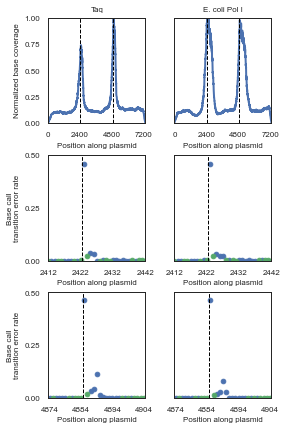

In [37]:
plt.figure(figsize = (4, 7))

coverage = [taqCov, polICov]
bases = [taqBases, polIBases]
enzymes = ['Taq', 'E. coli Pol I']

# read in plasmid reference, determine base transitions, and determine where a dPTP or dKTP would be incorporated
plasmidReference = readReference(data_dir + 'fig3/pilon_psrM01.fasta')
transition = baseTransitions(plasmidReference)
p = [i in 'CT' for i in plasmidReference]
k = [i in 'AG' for i in plasmidReference]

for i in range(2):
    plt.subplot(3, 2, i + 1)
    # normalize coverage data to be between 0 and 1, then plot
    plt.plot(range(len(coverage[i])), coverage[i] / max(coverage[i]))
    plt.ylim((0, 1))
    plt.xlim((0, 7305))
    plt.xticks([0, 2400, 4800, 7200])
    plt.xlabel('Position along plasmid')
    if i == 0:
        plt.ylabel('Normalized base coverage')
        plt.yticks([0, 0.25, 0.5, 0.75, 1])
    else:
        plt.yticks([])
    plt.title(enzymes[i], fontsize = 8)
    # put black dashed lines at nick sites
    plt.axvline(2422, lw = 1, ls = 'dashed', color = 'black')
    plt.axvline(4884, lw = 1, ls = 'dashed', color = 'black')
    
    plt.subplot(3, 2, i + 3)
    # plot transition mutation rate around the location of the left nick
    # sites where dPTP would be incorporated are blue, sites where dKTP would be incorporated are green
    plt.scatter([j for j in range(2412, 2443) if p[j]], [bases[i][j][transition[j]] for j in range(2412, 2443) if p[j]])
    plt.scatter([j for j in range(2412, 2443) if k[j]], [bases[i][j][transition[j]] for j in range(2412, 2443) if k[j]])
    plt.ylim((0, 0.5))
    plt.xlim((2412, 2442))
    plt.xticks([2412, 2422, 2432, 2442])
    plt.xlabel('Position along plasmid')
    if i == 0:
        plt.ylabel('Base call\ntransition error rate')
        plt.yticks([0, 0.25, 0.5])
    else:
        plt.yticks([])
    # put black dashed line at nick site
    plt.axvline(2422.5, ls = 'dashed', color = 'black', lw = 1)
               
    plt.subplot(3, 2, i + 5)
    # plot transition mutation rate around the location of the right nick
    # sites where dPTP would be incorporated are blue, sites where dKTP would be incorporated are green
    plt.scatter([j for j in range(4873, 4905) if p[j]], [bases[i][j][transition[j]] for j in range(4873, 4905) if p[j]])
    plt.scatter([j for j in range(4873, 4905) if k[j]], [bases[i][j][transition[j]] for j in range(4873, 4905) if k[j]])
    plt.ylim((0, 0.5))
    plt.xlim([4873.5, 4904.5])
    plt.xticks([4874, 4884, 4894, 4904])
    plt.xlabel('Position along plasmid')
    if i == 0:
        plt.ylabel('Base call\ntransition error rate')
        plt.yticks([0, 0.25, 0.5])
    else:
        plt.yticks([])
    # put black dashed line at nick site
    plt.axvline(4884.5, ls = 'dashed', color = 'black', lw = 1)
    
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S2.pdf', bbox_inches = 'tight', transparent = 'True')

### Figure S3

In [38]:
# load data for plasmid experiment with PCR by various DNA polymerases
files = ['taq', 'ventExo', 'NEBnext', 'kapa']
bases = []
coverage = []
for file in files:
    b, c = getData(data_dir + 'figS3/plasmid_' + file + 'PCR', 'plasmid_pilon', ['.sorted.bam', '.sorted.bam'])
    bases.append(b[0])
    coverage.append(c)

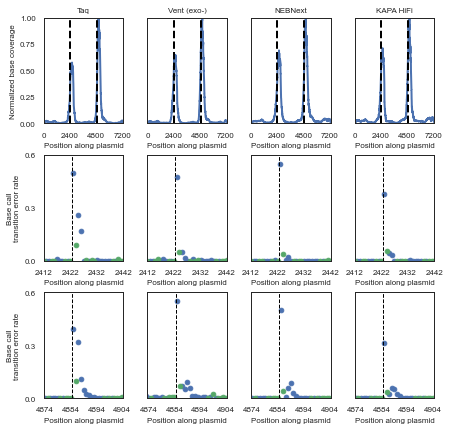

In [39]:
enzymes = ['Taq', 'Vent (exo-)', 'NEBNext', 'KAPA HiFi']
plt.figure(figsize = (7, 7))

for i in range(4):
    plt.subplot(3, 4, i + 1)
    # normalize coverage data to be between 0 and 1, then plot
    plt.plot(range(len(coverage[i])), coverage[i] / max(coverage[i]))
    plt.ylim((0, 1))
    plt.xlim((0, 7305))
    plt.xticks([0, 2400, 4800, 7200])
    plt.xlabel('Position along plasmid')
    if i == 0:
        plt.ylabel('Normalized base coverage')
        plt.yticks([0, 0.25, 0.5, 0.75, 1])
    else:
        plt.yticks([])
    plt.title(enzymes[i], fontsize = 8)
    # put black dashed lines at nick sites
    plt.axvline(2422, ls = 'dashed', color = 'black')
    plt.axvline(4884, ls = 'dashed', color = 'black')
    
    plt.subplot(3, 4, i + 5)
    # plot transition mutation rate around the location of the left nick
    # sites where dPTP would be incorporated are blue, sites where dKTP would be incorporated are green
    plt.scatter([j for j in range(2412, 2443) if p[j]], [bases[i][j][transition[j]] for j in range(2412, 2443) if p[j]])
    plt.scatter([j for j in range(2412, 2443) if k[j]], [bases[i][j][transition[j]] for j in range(2412, 2443) if k[j]])
    plt.ylim((0, 0.6))
    plt.xlim((2412, 2442))
    plt.xticks([2412, 2422, 2432, 2442])
    plt.xlabel('Position along plasmid')
    if i == 0:
        plt.ylabel('Base call\ntransition error rate')
        plt.yticks([0, 0.3, 0.6])
    else:
        plt.yticks([])
    # put black dashed line at nick site
    plt.axvline(2422.5, ls = 'dashed', color = 'black', lw = 1)
               
    plt.subplot(3, 4, i + 9)
    # plot transition mutation rate around the location of the right nick
    # sites where dPTP would be incorporated are blue, sites where dKTP would be incorporated are green
    plt.scatter([j for j in range(4873, 4905) if p[j]], [bases[i][j][transition[j]] for j in range(4873, 4905) if p[j]])
    plt.scatter([j for j in range(4873, 4905) if k[j]], [bases[i][j][transition[j]] for j in range(4873, 4905) if k[j]])
    plt.ylim((0, 0.6))
    plt.xlim([4873.5, 4904.5])
    plt.xticks([4874, 4884, 4894, 4904])
    plt.xlabel('Position along plasmid')
    if i == 0:
        plt.ylabel('Base call\ntransition error rate')
        plt.yticks([0, 0.3, 0.6])
    else:
        plt.yticks([])
    # put black dashed line at nick site
    plt.axvline(4884.5, ls = 'dashed', color = 'black', lw = 1)
    
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S3.pdf', bbox_inches = 'tight', transparent = 'True')

### Figure S4

In [40]:
# load data for plasmid experiment where pulldown with desthiobiotin-dCTP is tested
desthioCpull = countCoverage(data_dir + 'figS4/plasmid_desthiobiotindCTP_pulldown.sorted.bam', 'plasmid_pilon')
desthioCelu = countCoverage(data_dir + 'figS4/plasmid_desthiobiotindCTP_pulldownAndElution.sorted.bam', 'plasmid_pilon')
biotinPull_C = countCoverage(data_dir + 'figS4/plasmid_DTBdCTPcomparison_biotindUTP_pulldown.sorted.bam', 'plasmid_pilon')

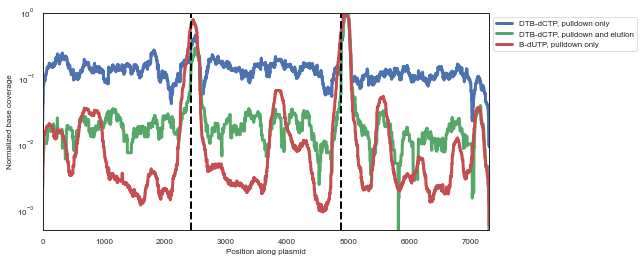

In [41]:
plt.figure(figsize = (8, 4))

# normalize coverage data to be between 0 and 1, then plot
for cov in [desthioCpull, desthioCelu, biotinPull_C]:
    plt.plot(range(len(cov)), cov / max(cov), lw = 3)
plt.xlabel('Position along plasmid')
plt.ylim([0.0005, 1])
plt.yscale('log')
plt.ylabel('Normalized base coverage')
plt.legend(('DTB-dCTP, pulldown only', 'DTB-dCTP, pulldown and elution', 'B-dUTP, pulldown only'), loc = "upper left", bbox_to_anchor = (1, 1), markerscale = 2)
# put black dashed lines at nick sites
plt.axvline(2422, c = 'black', ls = 'dashed', ymin = 0)
plt.axvline(4884, c = 'black', ls = 'dashed', ymin = 0)
plt.xlim(0, 7305)

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S4A.pdf', bbox_inches = 'tight', transparent = 'True')

In [42]:
# load data for plasmid experiment where pulldown with desthiobiotin-dATP is tested
desthioApull = countCoverage(data_dir + 'figS4/plasmid_desthiobiotindATP_pulldown.sorted.bam', 'plasmid_pilon')
desthioAelu = countCoverage(data_dir + 'figS4/plasmid_desthiobiotindATP_pulldownAndElution.sorted.bam', 'plasmid_pilon')
biotinPull_A = countCoverage(data_dir + 'figS4/plasmid_DTBdATPcomparison_biotindUTP_pulldown.sorted.bam', 'plasmid_pilon')

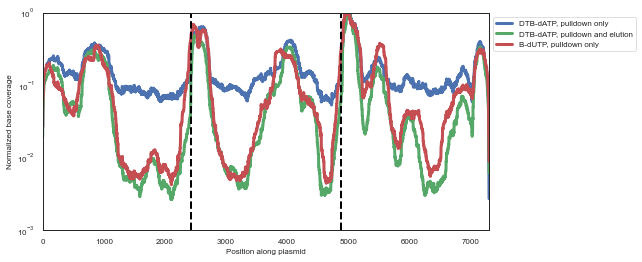

In [43]:
plt.figure(figsize = (8, 4))

# normalize coverage data to be between 0 and 1, then plot
for cov in [desthioApull, desthioAelu, biotinPull_A]:
    plt.plot(range(len(cov)), cov / max(cov), lw = 3)
plt.xlabel('Position along plasmid')
plt.ylim([0.001, 1])
plt.yscale('log')
plt.ylabel('Normalized base coverage')
plt.legend(('DTB-dATP, pulldown only', 'DTB-dATP, pulldown and elution', 'B-dUTP, pulldown only'), loc = "upper left", bbox_to_anchor = (1, 1), markerscale = 2)
# put black dashed lines at nick sites
plt.axvline(2422, c = 'black', ls = 'dashed', ymin = 0)
plt.axvline(4884, c = 'black', ls = 'dashed', ymin = 0)
plt.xlim(0, 7305)

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S4B.pdf', bbox_inches = 'tight', transparent = 'True')

### Figure S5

In [44]:
# load data for plasmid experiment with various dNTP concentrations used during nick translation
x4 = countCoverage(data_dir + 'figS5/plasmid_4xdNTP.noDup.bam', 'plasmid_pilon')
x2 = countCoverage(data_dir + 'figS5/plasmid_2xdNTP.noDup.bam', 'plasmid_pilon')
x1 = countCoverage(data_dir + 'fig3/plasmid_NbBsmI.noDup.bam', 'plasmid_pilon')

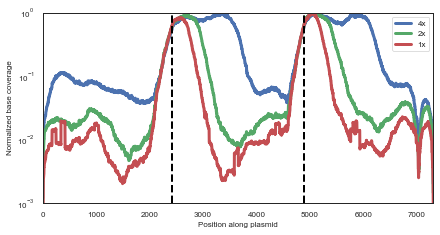

In [45]:
plt.figure(figsize = (7, 3.5))

# normalize coverage data to be between 0 and 1, then plot
for c in [x4, x2, x1]:
    plt.plot(range(len(c)), c / max(c), lw = 3)

plt.ylim([0.001, 1])
plt.xlim([0, 7305])

# put black dashed lines at nick sites
plt.axvline(2422, c = 'black', ls = 'dashed')
plt.axvline(4884, c = 'black', ls = 'dashed')

plt.yscale('log')

plt.ylabel('Normalized base coverage')
plt.xlabel('Position along plasmid')
plt.legend(['4x', '2x', '1x'], markerscale = 2)

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S5.pdf', bbox_inches = 'tight', transparent = 'True')

### Figure S6

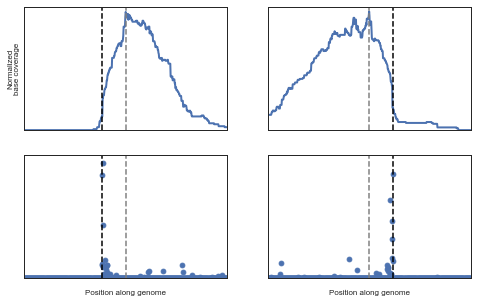

In [46]:
# plot figure displaying the expected outcome for reference vs. non-reference strand nicks
# code for Fig. 5 must be run before this, since this utilizes that data

m = max(genomeCov)

plt.figure(figsize = (8, 5))

count = 0

# data will be plotted for nicks 2 (reference strand) and 6 (non-reference strand)
for i in [2, 6]:
    count += 1
    # identify MACS2 peak that contains the relevant nick
    peak = peaks[(peaks.start < calledNicks[i]) & (peaks.end > calledNicks[i])].iloc[0]
    plt.subplot(2, 2, count)
    plt.xticks([])
    plt.yticks([])
    # determine location in the MACS2 peak with the highest coverage
    ind = peak.start + np.argmax(genomeCov[peak.start:peak.end + 1])
    # ind2 determines x range of plot, 300 bases will be plot up and downstream of the maximum coverage location
    ind2 = 300
    plt.ylim(0, genomeCov[ind] / m + 0.025)
    plt.xlim([ind - ind2, ind + ind2])
    # normalize coverage data to be between 0 and 1, then plot
    plt.plot(range(ind - ind2, ind + ind2 + 1), genomeCov[ind - ind2:ind + ind2 + 1] / m)
    if count == 1:
        plt.ylabel('Normalized\nbase coverage')
    # put a black dashed line at the nick site
    plt.axvline(calledNicks[i], ls = 'dashed', color = 'black', lw = 1.5)
    # put a gray dashed line at the site of maximum coverage
    plt.axvline(ind, ls = 'dashed', color = 'gray', lw = 1.5)

    plt.subplot(2, 2, count + 2)
    plt.xlim([ind - ind2, ind + ind2])
    # calculate and plot transition mutation rate
    transition = baseTransitions(genomeReference[ind - ind2:ind + ind2 + 1])
    toPlot = np.array([genomeBases[i + ind - ind2][transition[i]] for i in range(len(transition))])
    toPlot[np.isnan(toPlot)] = 0
    plt.scatter(range(ind - ind2, ind + ind2 + 1), toPlot, s = 24)
    if count == 0:
        plt.ylabel('Base call\ntransition error rate')
    plt.yticks([])
    plt.xlabel('\nPosition along genome')
    plt.xticks([])
    plt.ylim(0, 0.3)
    # put a black dashed line at the nick site
    plt.axvline(calledNicks[i], ls = 'dashed', color = 'black', lw = 1.5)
    # put a gray dashed line at the site of maximum coverage
    plt.axvline(ind, ls = 'dashed', color = 'gray', lw = 1.5)

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S6.pdf', bbox_inches = 'tight', transparent = 'True')

### Figure S7

In [47]:
# read in reference sequences for the two different plasmids used
plasmidReference = readReference(data_dir + 'fig3/pilon_psrM01.fasta')
plasmidReference2 = readReference(data_dir + 'fig4/pMN00_targetInsertAAVS1.fasta')
# determine where dPTP and dKTP would be incorporated for one of the plasmids
p = [i in 'CT' for i in plasmidReference]
k = [i in 'AG' for i in plasmidReference]

In [48]:
# read in MACS2 called peaks for serial dilutions of nicked plasmid in non-nicked plasmid
files = ['100', '10', '1', '0_1', '0_01']
dilutionPeaks = [[] for _ in range(5)]
for i in range(5):
    # call MACS2 on dataset (if needed, can also be done beforehand in Terminal) and load the called peaks
    #os.system('macs2 callpeak -t ' + data_dir + 'figS7/plasmid_nick' + files[i] + 'p.rmDup.bam -g ' + str(len(plasmidReference2) + (10 ** i - 1) * len(plasmidReference)) + ' --nomodel -n ' + data_dir + 'figS7/plasmid_nick' + files[i] + 'p')
    dilutionPeaks[i] = loadPeaks(data_dir + 'figS7/plasmid_nick' + files[i] + 'p_peaks.xls')

# identify minimum and maximum bounds of nick-containing MACS2 peaks across all files
dilutionPeak1 = [1142, 1142]
dilutionPeak2 = [4010, 4010]
for dilPeak in dilutionPeaks:
    # specifying chromosome and q value in this way limits MACS2 peaks to only those containing the nicks
    temp = dilPeak[(dilPeak.chromosome == 'pMN00_target') & (dilPeak.logQ > 6)]
    if not temp.empty:
        # set nick-containing peak bounds to those of the current MACS2 peaks if they are wider
        dilutionPeak1 = [min(dilutionPeak1[0], temp.loc[0, 'start']), max(dilutionPeak1[1], temp.loc[0, 'end'])]
        dilutionPeak2 = [min(dilutionPeak2[0], temp.loc[1, 'start']), max(dilutionPeak2[1], temp.loc[1, 'end'])]

In [49]:
def readInPeak(read, p1, p2):
    #Determine if the specified read is in one of the two MACS2 peaks that contains a nick
    
    # return 1 if the read is in the left nick-containing peak
    if (read.reference_start <= p1[1] or read.next_reference_start <= p1[1]) and (read.reference_end >= p1[0] or read.next_reference_start + len(read.query_sequence) >= p1[0]):
        return 1
    # return 2 if the read is in the right nick-containing peak
    elif (read.reference_start <= p2[1] or read.next_reference_start <= p2[1]) and (read.reference_end >= p2[0] or read.next_reference_start + len(read.query_sequence) >= p2[0]):
        return 2
    # return 0 if the read isn't in either nick-containing peak
    else:
        return 0

peak1ReadCounts = [0] * 5
peak2ReadCounts = [0] * 5
totalReadCounts = [0] * 5
# the GoodCov array stores read counts for reads that are located within one of the nick-containing MACS2 peaks
plasmid1GoodCov = [np.array([0] * len(plasmidReference2)) for _ in range(5)]
# the BadCov array stores read counts for reads that are not located within either nick-containing MACS2 peak
plasmid1BadCov = [np.array([0] * len(plasmidReference2)) for _ in range(5)]
plasmid2Cov = [np.array([0] * len(plasmidReference)) for _ in range(5)]
insertLength = []
# loop through each level of dilution
for i in range(5):
    # load the appropriate data file
    samfile = pysam.AlignmentFile(data_dir + 'figS7/plasmid_nick' + files[i] + 'p.rmDup.bam')
    # read all data mapped to the nicked plasmid
    for read in samfile.fetch('pMN00_target'):
        if read.is_proper_pair and read.mapping_quality >= 30:
            start = read.reference_start
            mateStart = read.next_reference_start
            if start > mateStart or (start == mateStart and read.mate_is_reverse):
                stop = read.reference_end
                # determine if the read is in one of the nick-containing MACS2 peaks
                whichPeak = readInPeak(read, dilutionPeak1, dilutionPeak2) 
                if whichPeak:
                    plasmid1GoodCov[i][mateStart:stop] += 1
                    if whichPeak == 1:
                        peak1ReadCounts[i] += 1
                    else:
                        peak2ReadCounts[i] += 1
                else:
                    plasmid1BadCov[i][mateStart:stop] += 1
                totalReadCounts[i] += 1
                insertLength.append(stop - mateStart)
    # read all data mapped to the non-nicked plasmid
    for read in samfile.fetch('plasmid_pilon'):
        if read.is_proper_pair and read.mapping_quality >= 30:
            start = read.reference_start
            mateStart = read.next_reference_start
            if start > mateStart or (start == mateStart and read.mate_is_reverse):
                stop = read.reference_end
                plasmid2Cov[i][mateStart:stop] += 1
                totalReadCounts[i] += 1
                insertLength.append(stop - mateStart)
    samfile.close()
insertLength = int(round(np.mean(insertLength)))

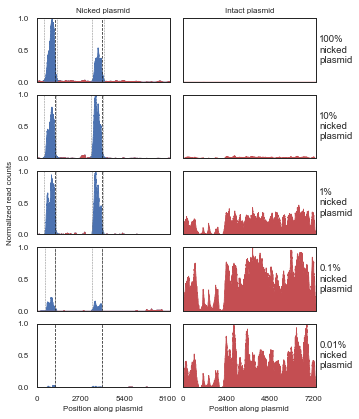

In [50]:
# plot read coverage across both plasmids for all dilution values

qThreshold = 6
            
plt.figure(figsize = (5, 11))
for i in range(5):
    # determine maximum coverage to properly set the y range
    yLimit = max(np.concatenate([plasmid1GoodCov[i] + plasmid1BadCov[i], plasmid2Cov[i]]))
    plt.subplot(8, 2, 2 * i + 1)
    # plot reads in plasmid 1 that are within a nick-containing MACS2 peak in blue
    plt.fill_between(range(len(plasmidReference2)), (plasmid1GoodCov[i] + plasmid1BadCov[i]) / yLimit, color = blue)
    # plot reads in plasmid 1 that aren't within a nick-containing MACS2 peak in red
    plt.fill_between(range(len(plasmidReference2)), plasmid1BadCov[i] / yLimit, color = red)
    # put black dashed lines at the nick sites
    plt.axvline(1141.5, c = 'k', ls = 'dashed', lw = 0.75)
    plt.axvline(4009.5, c = 'k', ls = 'dashed', lw = 0.75)
    # put gray dashed lines at the bounds of the nick-containing MACS2 peaks
    for _, dilPeak in dilutionPeaks[i][(dilutionPeaks[i].chromosome == 'pMN00_target') & (dilutionPeaks[i].logQ >= qThreshold)].iterrows():
        plt.axvline(dilPeak.start, c = 'gray', ls = 'dashed', lw = 0.5)
        plt.axvline(dilPeak.end, c = 'gray', ls = 'dashed', lw = 0.5)
    plt.xlim(0, len(plasmidReference2))
    plt.ylim(0, 1)
    plt.yticks([0, 0.5, 1])
    if i < 4:
        plt.xticks([])
        if i == 2:
            plt.ylabel('Normalized read counts')
        elif i == 0:
            plt.title('Nicked plasmid', fontsize = 8)
    else:
        plt.xlabel('Position along plasmid')
        plt.xticks([0, 2700, 5400, 8100])

    plt.subplot(8, 2, 2 * i + 2)
    # plot reads in plasmid 2 in red
    plt.fill_between(range(len(plasmidReference)), plasmid2Cov[i] / yLimit, color = red)
    plt.xlim(0, len(plasmidReference))
    plt.ylim(0, 1)
    plt.yticks([])
    if i < 4:
        plt.xticks([])
        if i == 0:
            plt.title('Intact plasmid', fontsize = 8)
    else:
        plt.xlabel('Position along plasmid')
        plt.xticks([0, 2400, 4800, 7200])
    plt.text(7500, 0.3, files[i].replace('_', '.') + '%\nnicked\nplasmid')
        
plt.subplots_adjust(hspace = 0.2, wspace = 0.1)

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S7A.pdf', bbox_inches = 'tight', transparent = 'True')

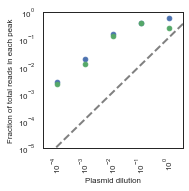

In [51]:
# plot the fraction of total reads that are within the nick-containing MACS2 peaks

# calculate expected number of reads in each peak if no enrichment were performed
# calculation is based on peak width, plasmid reference length, and insert length of sequenced reads
fractionExpectedInPeaks = (dilutionPeak1[1] - dilutionPeak1[0] + dilutionPeak2[1] - dilutionPeak2[0] + insertLength * 2 + 2) / (len(plasmidReference2) - insertLength)

plt.figure(figsize = (2.5, 2.5))

# plot the fraction of total reads that are within the left nick-containing MACS2 peak
plt.scatter([10 ** -i for i in range(5)], [peak1ReadCounts[i] / totalReadCounts[i] for i in range(5)], c = [blue])
# plot the fraction of total reads that are within the right nick-containing MACS2 peak
plt.scatter([10 ** -i for i in range(5)], [peak2ReadCounts[i] / totalReadCounts[i] for i in range(5)], c = [green])
# plot the fraction of total reads expected to be in the nick-containing MACS2 peaks without enrichment
plotLine = np.array([0.00005, 5])
plt.plot(plotLine, plotLine / 2 * fractionExpectedInPeaks, ls = 'dashed', c = 'gray')
plt.xlabel('Plasmid dilution')
plt.ylabel("Fraction of total reads in each peak")
plt.xscale('log')
plt.yscale('log')
plt.ylim([0.00001, 1])
plt.xlim([0.000031623, 3.1623])
plt.xticks([10 ** i for i in range(-4, 1)], rotation = 'vertical')

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S7B.pdf', bbox_inches = 'tight', transparent = 'True')

In [52]:
# load data to simulate dilutions, note these files have duplicates removed
# positive control is from a sample where plasmid was nicked by Nb.BsmI
# negative control is from a sample where plasmid received no nicking treatment
positiveControl = pysam.AlignmentFile(data_dir + 'fig3/plasmid_NbBsmI.noDup.bam')
negativeControl = pysam.AlignmentFile(data_dir + 'fig3/plasmid_noNicks.noDup.bam')

# call MACS2 on dataset (if needed, can also be done beforehand in Terminal) and load the called peaks
# os.system('macs2 callpeak -t ' + data_dir + 'fig3/plasmid_NbBsmI.sorted.bam -g 7305 --nomodel -n ' + data_dir + 'fig3/plasmid_NbBsmI')
# read in MACS2 peaks from the nicked sample
posPeaks = loadPeaks(data_dir + 'fig3/plasmid_NbBsmI_peaks.xls')
peak1 = list(posPeaks.loc[0, ['start', 'end']])
peak2 = list(posPeaks.loc[1, ['start', 'end']])

# determine number of reads in each MACS2 peak from the nicked sample
# this will help determine maximum read depth of simulated data
maxReadsPeak1 = 0
maxReadsPeak2 = 0
for read in positiveControl.fetch('plasmid_pilon'):
    if read.is_proper_pair and read.mapping_quality >= 30:
        temp = readInPeak(read, peak1, peak2)
        if temp == 1:
            maxReadsPeak1 += 1
        elif temp == 2:
            maxReadsPeak2 += 1
# determine number of reads in the non-nicked sample
# this will help determine maximum read depth of simulated data
maxReadsOff = negativeControl.mapped

# divide all values by two since they apply for individual reads, but we will be working with them as read pairs
maxReadsPeak1 /= 2
maxReadsPeak2 /= 2
maxReadsOff /= 2

In [53]:
onCount = [0] * 5
offCount = [0] * 5
onCov = [np.array([0] * 7305) for _ in range(5)]
onLocs = [[[] for _ in range(7305)] for _ in range(5)]
offCov = [np.array([0] * 7305) for _ in range(5)]
offLocs = [[[] for _ in range(7305)] for _ in range(6)]
if not os.path.exists(data_dir + 'figS7/temp/'):
    os.mkdir(data_dir + 'figS7/temp/')
# loop through each level of dilution
for i in range(5):
    # determine maximum read depth of simulated data based on number of reads in positive and negative controls
    p1 = peak1ReadCounts[i]
    p2 = peak2ReadCounts[i]
    t = totalReadCounts[i]
    maxReads = math.floor(min([(maxReadsPeak1 + maxReadsPeak2) / ((p1 + p2) / t), maxReadsOff / ((t - p1 - p2) / t)]))
    
    # determine number of reads in each MACS2 peak and number of off-target reads
    p1NumReads = round(maxReads * (p1 + p2) / t * maxReadsPeak1 / (maxReadsPeak1 + maxReadsPeak2))
    p2NumReads = round(maxReads * (p1 + p2) / t * maxReadsPeak2 / (maxReadsPeak1 + maxReadsPeak2))
    offNumReads = round(maxReads * (t - p1 - p2) / t)
    
    # randomly choose the appropriate numbers of on- and off-target reads
    p1Reads = sorted(random.sample(range(int(maxReadsPeak1)), p1NumReads))
    p2Reads = sorted(random.sample(range(int(maxReadsPeak2)), p2NumReads))
    onReadNames = []
    offReads = sorted(random.sample(range(int(maxReadsOff)), offNumReads))
    offReadNames = []
    
    p1Index = 0
    p1Loc = 0
    p2Index = 0
    p2Loc = 0
    # loop through all reads in the nicked sample
    for read in positiveControl.fetch('plasmid_pilon'):
        if read.is_proper_pair and read.mapping_quality >= 30 and (read.reference_start > read.next_reference_start or (read.reference_start == read.next_reference_start and read.mate_is_reverse)):
            # determine if read is in a MACS2 peak
            whichPeak = readInPeak(read, peak1, peak2)
            if whichPeak == 1:
                # if in the left peak, check if the read was selected for inclusion in the simulated data set
                if p1Index < len(p1Reads) and p1Reads[p1Index] == p1Loc:
                    onCov[i][read.next_reference_start:read.reference_end] += 1
                    onLocs[i][read.next_reference_start].append(read.reference_start)
                    p1Index += 1
                    onCount[i] += 1
                    onReadNames.append(read.query_name)
                p1Loc += 1
            elif whichPeak == 2:
                # if in the right peak, check if the read was selected for inclusion in the simulated data set
                if p2Index < len(p2Reads) and p2Reads[p2Index] == p2Loc:
                    onCov[i][read.next_reference_start:read.reference_end] += 1
                    onLocs[i][read.next_reference_start].append(read.reference_start)
                    p2Index += 1
                    onCount[i] += 1
                    onReadNames.append(read.query_name)
                p2Loc += 1
    offIndex = 0
    offLoc = 0
    # loop through all reads in the non-nicked sample
    for read in negativeControl.fetch('plasmid_pilon'):
        if read.is_proper_pair and read.mapping_quality >= 30 and (read.reference_start > read.next_reference_start or (read.reference_start == read.next_reference_start and read.mate_is_reverse)):
            # check if the read was selected for inclusion in the simulated data set
            if offIndex < len(offReads) and offReads[offIndex] == offLoc:
                offCov[i][read.next_reference_start:read.reference_end] += 1
                offLocs[i][read.next_reference_start].append(read.reference_start)
                offIndex += 1
                offCount[i] += 1
                offReadNames.append(read.query_name)
            offLoc += 1
    
    # the following code is commented out to save time, it is only required to perform MACS2 on the simulated data
    # create a file to save the selected reads to
    #fileName = data_dir + 'figS7/temp/diluted_1e-' + str(i) + '.noDup.bam'
    #writeFile = pysam.AlignmentFile(fileName, 'wb', template = samfile)
    # write reads to the newly created file if they are meant to be included in the simulated data
    #for read in onTargetReads.fetch('plasmid_pilon'):
    #    if read.query_name in onReadNames:
    #        writeFile.write(read)
    #for read in offTargetReads.fetch('plasmid_pilon'):
    #    if read.query_name in offReadNames:
    #        writeFile.write(read)
    #writeFile.close()
    # run MACS2 on the newly created file
    #os.system('macs2 callpeak -t ' + fileName + ' -f BAMPE --keep-dup all -g 7305 --nomodel -n ' + fileName[:-10])

# get data for having absolutely no nicked plasmid in sample
negCov = np.array([0] * 7305)
for read in negativeControl.fetch('plasmid_pilon'):
    if read.is_proper_pair and read.mapping_quality >= 30 and (read.reference_start > read.next_reference_start or (read.reference_start == read.next_reference_start and read.mate_is_reverse)):
        negCov[read.next_reference_start:read.reference_end] += 1
        offLocs[5][read.next_reference_start].append(read.reference_start)
# run MACS2 on the non-nicked sample
#os.system('macs2 callpeak -t ' + data_dir + 'fig3/plasmid_noNicks.noDup.bam -f BAMPE --keep-dup all -g 7305 --nomodel -n ' + data_dir + 'figS7/temp/neg')

positiveControl.close()
negativeControl.close()

In [54]:
def readsToBaseCalls(reads, cigars, qualities, startIndices):
    #Given a list of reads, return base call frequencies at each position
    
    # reads must first be fixed, i.e. indels and low-quality base calls must be dealt with
    fixedReads = []
    for j in range(len(reads)):
        # delete base calls with low quality score
        qual = np.array([int(x) for x in qualities[j][1:-1].split(', ')])
        temp = np.array(list(reads[j]))
        temp[qual < 30] = 'N'
        # deal with indels in read
        ind = 0
        read = np.array([])
        cigarType = re.findall('[MDI]', cigars[j])
        cigarLength = [int(x) for x in re.split('[MDI]', cigars[j])[:-1]]
        for x in range(len(cigarType)):
            # if the CIGAR string says M, the bases map to the reference and base calls are kept
            if cigarType[x] == 'M':
                # query and reference are both consumed
                read = np.concatenate([read, temp[ind:ind + cigarLength[x]]])
                ind += cigarLength[x]
            # if the CIGAR string says D, the bases are deletions relative to the reference
            # deleted bases from the reference have N values inserted into the read
            elif cigarType[x] == 'D':
                # reference is consumed, query is not
                read = np.concatenate([read, ['N'] * cigarLength[x]])
            # if the CIGAR string says I, the bases are insertions relative to the reference
            # inserted bases in the read are ignored
            else:
                # query is consumed, reference is not
                ind += cigarLength[x]
        fixedReads.append(read)
    
    # base calls are extracted from all fixed reads based on read sequence and start position
    baseCallsA = np.array([0] * 7305)
    baseCallsC = np.array([0] * 7305)
    baseCallsG = np.array([0] * 7305)
    baseCallsT = np.array([0] * 7305)
    for j in range(len(fixedReads)):
        baseCallsA[startIndices[j] + np.where(fixedReads[j] == 'A')[0]] += 1
        baseCallsC[startIndices[j] + np.where(fixedReads[j] == 'C')[0]] += 1
        baseCallsG[startIndices[j] + np.where(fixedReads[j] == 'G')[0]] += 1
        baseCallsT[startIndices[j] + np.where(fixedReads[j] == 'T')[0]] += 1
    
    # convert base calls to a dataframe indexed by base letter instead of number (e.g. A instead of 0)
    c = (baseCallsA, baseCallsC, baseCallsG, baseCallsT)
    cov = pd.DataFrame()
    for j in index:
        cov = pd.concat([cov, pd.DataFrame(c[j].tolist()).T])
    cov.index = index2
    readCount = cov.sum(axis = 0)
    return cov / readCount, readCount

# load data to simulate dilutions, note these files do not have duplicates removed
# positive control is from a sample where plasmid was nicked by Nb.BsmI
# negative control is from a sample where plasmid received no nicking treatment
positiveControl = pysam.AlignmentFile(data_dir + 'fig3/plasmid_NbBsmI.sorted.bam')
negativeControl = pysam.AlignmentFile(data_dir + 'fig3/plasmid_noNicks.sorted.bam')

bases = [[] for _ in range(6)]
rc = [[] for _ in range(6)]
# loop through each level of dilution
for i in range(5):
    numOnReads = 0
    numOffReads = 0
    # loop through all reads in the nicked sample and count the ones included in simulated data set
    for read in positiveControl.fetch('plasmid_pilon'):
        if read.is_proper_pair and read.reference_start in onLocs[i][read.next_reference_start]:
            numOnReads += 1
            # don't double count read pairs that start at the same location
            if read.reference_start == read.next_reference_start:
                numOnReads -= 0.5
    # loop through all reads in the non-nicked sample and count and count the ones included in simulated data set
    for read in negativeControl.fetch('plasmid_pilon'):
        if read.is_proper_pair and read.reference_start in offLocs[i][read.next_reference_start]:
            numOffReads += 1
            # don't double count read pairs that start at the same location
            if read.reference_start == read.next_reference_start:
                numOffReads -= 0.5
    
    # calculate duplication rate for the nicked and non-nicked sample files
    onDuplicationRate = numOnReads / onCount[i]
    offDuplicationRate = numOffReads / offCount[i]
    # duplication rate is higher in the nicked file
    if offDuplicationRate > onDuplicationRate:
        raise Exception('Unexpected: off-target read duplication rate exceeds on-target read duplication rate')
    # choose a random sample of the duplicate reads in the nicked file to keep
    # this ensures the duplication rate of reads coming from each file is equaivalent
    keep = sorted(random.sample(range(int(numOnReads)), round(offDuplicationRate / onDuplicationRate * float(numOnReads))))
    
    loc = 0
    ind = 0
    onReadNames = [[] for _ in range(7305)]
    # save read names of the reads in the nicked file that will be keep
    for read in positiveControl.fetch('plasmid_pilon'):
        if read.is_proper_pair and read.reference_start in onLocs[i][read.next_reference_start] and (read.reference_start != read.next_reference_start or read.mate_is_reverse):
            if ind < len(keep) and keep[ind] == loc:
                onReadNames[read.reference_start].append(read.query_name)
                ind += 1
            loc += 1
    
    reads = []
    cigars = []
    qualities = []
    startIndices = []
    # go through the nicked file and save information on all reads that will be used in the simulated data set
    for read in positiveControl.fetch('plasmid_pilon'):
        if read.is_proper_pair and (read.query_name in onReadNames[read.reference_start] or read.query_name in onReadNames[read.next_reference_start]):
            temp = str(read).split('\t')
            reads.append(temp[9])
            cigars.append(temp[5])
            qualities.append(temp[10][11:-1])
            startIndices.append(int(temp[3]))
    # go through the non-nicked file and save information on all reads that will be used in the simulated data set
    for read in negativeControl.fetch('plasmid_pilon'):
        if read.is_proper_pair and (read.reference_start in offLocs[i][read.next_reference_start] or read.next_reference_start in offLocs[i][read.reference_start]):
            temp = str(read).split('\t')
            reads.append(temp[9])
            cigars.append(temp[5])
            qualities.append(temp[10][11:-1])
            startIndices.append(int(temp[3]))
    # convert the saved read information into base calls
    bases[i], rc[i] = readsToBaseCalls(reads, cigars, qualities, startIndices)
    
positiveControl.close()

reads = []
cigars = []
qualities = []
startIndices = []
# save information on all reads in the non-nicked file (data for having absolutely no nicked plasmid in sample)
for read in negativeControl.fetch('plasmid_pilon'):
    if read.is_proper_pair and (read.reference_start in offLocs[5][read.next_reference_start] or read.next_reference_start in offLocs[5][read.reference_start]):
        temp = str(read).split('\t')
        reads.append(temp[9])
        cigars.append(temp[5])
        qualities.append(temp[10][11:-1])
        startIndices.append(int(temp[3]))
# convert the saved read information into base calls
bases[5], rc[5] = readsToBaseCalls(reads, cigars, qualities, startIndices)

negativeControl.close()

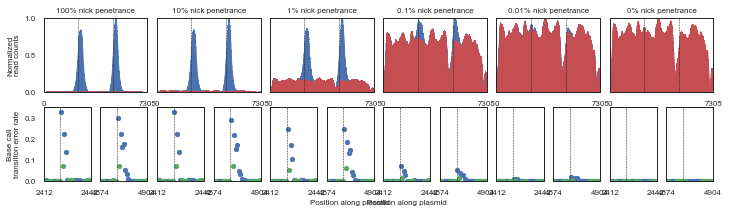

In [55]:
# plot read coverage and transition mutation rate for the various levels of dilution

# determine base transitions from plasmid reference sequence
transition = baseTransitions(plasmidReference)

plt.figure(figsize = (12, 3))
grid = plt.GridSpec(2, 12)
# for each dilution level
for i in range(6):
    plt.subplot(grid[0, 2 * i:2 * i + 2])
    # if this data set contains absolutely no nicked plasmid
    if i == 5:
        plt.title('0% nick penetrance', fontsize = 8)
        # plot all reads in red
        plt.fill_between(range(len(plasmidReference)), negCov / max(negCov), color = red)
    # if this data set is a dikution of some amount of nicked plasmid in non-nicked plasmid
    else:
        plt.title(files[i].replace('_', '.') + '% nick penetrance', fontsize = 8)
        m = max(onCov[i] + offCov[i])
        # plot reads coming from enrichment of nick sites in blue
        plt.fill_between(range(len(plasmidReference)), (onCov[i] + offCov[i]) / m, offCov[i] / m, color = blue)
        # plot other reads in red
        plt.fill_between(range(len(plasmidReference)), offCov[i] / m, color = red)
    plt.xlim(0, len(plasmidReference))
    plt.ylim(0, 1)
    # put black dashed lines at nick sites
    plt.axvline(2422.5, c = 'k', ls = 'dashed', lw = 0.5)
    plt.axvline(4884.5, c = 'k', ls = 'dashed', lw = 0.5)
    plt.xticks([0, len(plasmidReference)])
    if i == 0:
        plt.ylabel('Normalized\nread counts')
        plt.yticks([0, 0.5, 1])
    else:
        plt.yticks([])
    
    plt.subplot(grid[1, 2 * i])
    y = [bases[i][j][transition[j]] for j in range(len(plasmidReference))]
    # plot transition mutation rate around the location of the left nick
    # sites where dPTP would be incorporated are blue, sites where dKTP would be incorporated are green
    plt.scatter([j for j in range(2412, 2443) if p[j]], [y[j] for j in range(2412, 2443) if p[j]], s = 20)
    plt.scatter([j for j in range(2412, 2443) if k[j]], [y[j] for j in range(2412, 2443) if k[j]], s = 20)
    if i == 0:
        plt.ylabel('Base call\ntransition error rate')
        plt.yticks([0, 0.1, 0.2, 0.3])
    else:
        plt.yticks([])
    plt.ylim(0, 0.35)
    plt.xlim(2411.5, 2442.5)
    # put black dashed line at nick site
    plt.axvline(2422.5, c = 'k', ls = 'dashed', lw = 0.5)
    plt.xticks([2412, 2442])
    if i == 3:
        plt.xlabel('Position along plasmid')
    
    plt.subplot(grid[1, 2 * i + 1])
    # plot transition mutation rate around the location of the right nick
    # sites where dPTP would be incorporated are blue, sites where dKTP would be incorporated are green
    plt.scatter([j for j in range(4874, 4905) if p[j]], [y[j] for j in range(4874, 4905) if p[j]], s = 20)
    plt.scatter([j for j in range(4874, 4905) if k[j]], [y[j] for j in range(4874, 4905) if k[j]], s = 20)
    plt.yticks([])
    plt.ylim(0, 0.35)
    plt.xlim(4873.5, 4904.5)
    # put black dashed line at nick site
    plt.axvline(4884.5, c = 'k', ls = 'dashed', lw = 0.5)
    plt.xticks([4874, 4904])
    if i == 2:
        plt.xlabel('Position along plasmid')

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S7C.pdf', bbox_inches = 'tight', transparent = 'True')

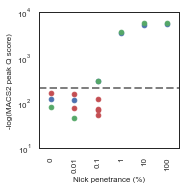

In [56]:
# plot MACS2 peak q scores for the various levels of dilution

plt.figure(figsize = (2.5, 2.5))

# for each level of dilution
for i in range(6):
    # read in appropriate MACS2 peaks
    if i == 5:
        plasmidPeaks = loadPeaks(data_dir + 'figS7/temp/neg_peaks.xls', 20)
    else:
        plasmidPeaks = loadPeaks(data_dir + 'figS7/temp/diluted_1e-' + str(i) + '_peaks.xls', 20)
    temp1 = plasmidPeaks[(plasmidPeaks.start < 2422) & (plasmidPeaks.end > 2422)].index
    temp2 = plasmidPeaks[(plasmidPeaks.start < 4924) & (plasmidPeaks.end > 4884)].index
    temp3 = plasmidPeaks.drop([temp1[0], temp2[0]])
    # plot off-target peaks in red
    plt.scatter([10 ** -i] * len(temp3), temp3.logQ, c = [red])
    # plot peaks that contain the left nick in blue
    plt.scatter([10 ** -i] * len(temp1), plasmidPeaks.loc[temp1, 'logQ'], c = [blue])
    # plot peaks that contain the right nick in green
    plt.scatter([10 ** -i] * len(temp2), plasmidPeaks.loc[temp2, 'logQ'], c = [green])
    
plt.yscale('log')
plt.xscale('log')
plt.xlim([0.0000031623, 3.1623])
plt.ylim(10, 10000)
# plot a dashed line separating low from high q value MACS2 peaks
plt.axhline(215, ls = 'dashed', c = 'gray')
plt.xlabel('Nick penetrance (%)')
plt.ylabel('-log(MACS2 peak Q score)')
plt.xticks([10 ** i for i in range(-5, 1)])
plt.gca().set_xticklabels(['0'] + [s.replace('_', '.') for s in files[::-1]], rotation = 'vertical')

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S7D.pdf', bbox_inches = 'tight', transparent = 'True')

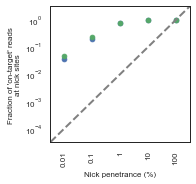

In [57]:
# plot fraction of reads at the nick sites that are 'on-target' versus the expected amount without enrichment

plt.figure(figsize = (2.5, 2.5))

# plot fraction of 'on-target' reads at left nick site
plt.scatter([10 ** -i for i in range(5)], [onCov[i][2423] / (onCov[i][2423] + offCov[i][2423]) for i in range(5)], c = [blue])
# plot fraction of 'on-target' reads at right nick site
plt.scatter([10 ** -i for i in range(5)], [onCov[i][4885] / (onCov[i][4885] + offCov[i][4885]) for i in range(5)], c = [green])
# plot fraction of 'on-target' reads expected if no enrichment were performed
# this is just equal to the dilution level of nicked plasmid in non-nicked plasmid
plt.plot([0.000005, 5], [0.000005, 5], ls = 'dashed', c = 'gray')
plt.xlabel('Nick penetrance (%)')
plt.ylabel("Fraction of 'on-target' reads\nat nick sites")
plt.xscale('log')
plt.yscale('log')
plt.ylim([0.000031623, 3.1623])
plt.xlim([0.000031623, 3.1623])
plt.xticks([10 ** i for i in range(-4, 1)])
plt.gca().set_xticklabels([s.replace('_', '.') for s in files[::-1]], rotation = 'vertical')

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S7E.pdf', bbox_inches = 'tight', transparent = 'True')

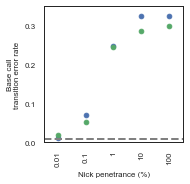

In [58]:
# plot transition mutation signal at each nick site for the various levels of dilution

plt.figure(figsize = (2.5, 2.5))

# plot transition mutation signal at the left nick site in blue
plt.scatter([10 ** -i for i in range(5)], [bases[i][2423][transition[2423]] for i in range(5)], c = [blue])
# plot transition mutation signal at the left nick site in blue
plt.scatter([10 ** -i for i in range(5)], [bases[i][4885][transition[4885]] for i in range(5)], c = [green])
# plot a dashed line displaying low transition mutation signal
plt.axhline(max([bases[5][x][transition[x]] for x in range(5, 7300)]), c = 'gray', ls = 'dashed')
plt.xlabel('Nick penetrance (%)')
plt.ylabel('Base call\ntransition error rate')
plt.xscale('log')
plt.xlim([0.000031623, 3.1623])
plt.ylim(0.0001, 0.35)
plt.xticks([10 ** i for i in range(-4, 1)])
plt.gca().set_xticklabels([s.replace('_', '.') for s in files[::-1]], rotation = 'vertical')
plt.yticks([0, 0.1, 0.2, 0.3])

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S7F.pdf', bbox_inches = 'tight', transparent = 'True')

### Figure S8

In [59]:
# load data for plasmid nicked by Nb.BsmI that displays nicking endonuclease off-target activity (Fig. 4A/B data)
# original reads were mapped to a reference that contained two copies of the plasmid reference
# this helped enable proper mapping at the "beginning" and "end" of the reference sequence (since the reference is an artificially linear representation of circular DNA)
withPulldownBases, withPulldownCov = getData(data_dir + 'fig4/plasmid_NbBsmI_withOfftargets', 'plasmid_pilon')
withPulldownBases = pd.concat([withPulldownBases[0].iloc[:, 7305:10956], withPulldownBases[0].iloc[:, 3651:7305]], axis = 1)
withPulldownBases.columns = range(7305)
withPulldownCov = np.concatenate([withPulldownCov[7305:10956], withPulldownCov[3651:7305]])

# load data coming from same sample as the Fig. 4A/B data but that was left out of streptavidin pulldown
# original reads were mapped to a reference that contained two copies of the plasmid reference
# this helped enable proper mapping at the "beginning" and "end" of the reference sequence (since the reference is an artificially linear representation of circular DNA)
noPulldownBases, noPulldownCov = getData(data_dir + 'figS8/plasmid_NbBsmI_withOfftargets_noPulldown', 'plasmid_pilon')
noPulldownBases = pd.concat([noPulldownBases[0].iloc[:, 7305:10956], noPulldownBases[0].iloc[:, 3651:7305]], axis = 1)
noPulldownBases.columns = range(7305)
noPulldownCov = np.concatenate([noPulldownCov[7305:10956], noPulldownCov[3651:7305]])

# load plasmid reference and identify transition bases expected to result from dPTP/dKTP
plasmidReference = readReference(data_dir + 'fig3/pilon_psrM01.fasta')
transition = baseTransitions(plasmidReference)

# identify off-target nick loci in both samples
topNicksWithPD, bottomNicksWithPD = offtarget_NbBsmI_calls(withPulldownBases)
topNicksNoPD, bottomNicksNoPD = offtarget_NbBsmI_calls(noPulldownBases)

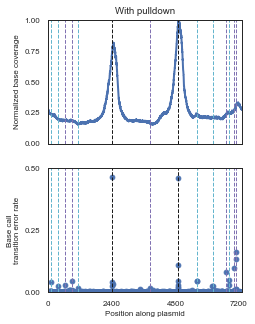

In [60]:
# plot base coverage and transition mutation rate for data with pulldown
plotPlasmidOffTargets(withPulldownBases, withPulldownCov, [2422, 4884], [i for i in topNicksWithPD if i not in [2422, 4884]], bottomNicksWithPD, reference = plasmidReference)
plt.subplot(2, 1, 1)
plt.title('With pulldown')
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S8A_left.pdf', bbox_inches = 'tight', transparent = 'True')

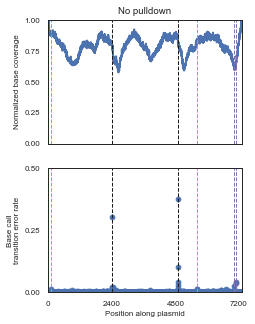

In [61]:
# plot base coverage and transition mutation rate for data without pulldown
plotPlasmidOffTargets(noPulldownBases, noPulldownCov, [2422, 4884], [i for i in topNicksNoPD if i not in [2422, 4884]], bottomNicksNoPD, reference = plasmidReference)
plt.subplot(2, 1, 1)
plt.title('No pulldown')
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S8A_right.pdf', bbox_inches = 'tight', transparent = 'True')

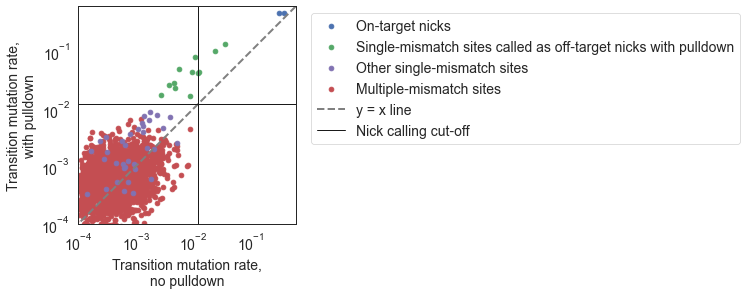

In [62]:
# plot transition rates across the plasmid compared for with and without pulldown

# identify locations with a single mismatch to the Nb.BsmI recognition sequence
locs = []
for i in range(len(plasmidReference) - 7):
    if hammingDistance(plasmidReference[i:i + 7], 'NGCATTC') < 2:
        locs.append(i + 2)
    elif hammingDistance(plasmidReference[i:i + 7], 'GAATGCN') < 2:
        locs.append(i + 4)
identifiedOfftargets = [i + 1 for i in topNicksWithPD if not i in [2422, 4884]] + bottomNicksWithPD
        
# data without pulldown goes on x axis
x = [noPulldownBases[i][transition[i]] for i in range(len(plasmidReference))]
# data with pulldown goes on y axis
y = [withPulldownBases[i][transition[i]] for i in range(len(plasmidReference))]

# plot multiple-mismatch loci in red
# loci are excluded from plotting if they are close to a single-mismatch locus
# this is due to mutational signal that could arise in such loci due to dPTP/dKTP at an off-target nick as opposed to noise
temp = [i for i in range(len(plasmidReference)) if min(abs(i - np.array(locs))) > 10 and y[i] < 0.01]
l4 = plt.scatter([x[i] for i in temp], [y[i] for i in temp], c = [red])
# plot single-mismatch loci that aren't identified off-targets in purple
temp = [i for i in locs if not i in identifiedOfftargets + [2423, 4885]]
l3 = plt.scatter([x[i] for i in temp], [y[i] for i in temp], c = [purple])
# plot identified off-target loci in green
l2 = plt.scatter([x[i] for i in identifiedOfftargets], [y[i] for i in identifiedOfftargets], c = [green])
# plot on-target Nb.BsmI loci in blue
l1 = plt.scatter([x[i] for i in [2423, 4885]], [y[i] for i in [2423, 4885]], c = [blue])

plt.xscale('log')
plt.yscale('log')
# plot y = x line to show which sample has higher signal for each data point
plt.plot([1e-5, 1], [1e-5, 1], ls = 'dashed', c = 'gray')
# plot a gray dashed line that isn't within the axis limits - only used to get a handle for the legend
l5 = plt.axhline(1, c = 'gray', ls = 'dashed')
plt.axis('scaled')
plt.xlim(1e-4, 0.6)
plt.ylim(1e-4, 0.6)
# plot a vertical and horizontal line at the mutational signal cutoff for off-target identification
l6 = plt.axhline(0.012, c = 'k', lw = 1)
plt.axvline(0.012, c = 'k', lw = 1)
plt.ylabel('Transition mutation rate,\nwith pulldown', fontsize = 14)
plt.xlabel('Transition mutation rate,\nno pulldown', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend([l1, l2, l3, l4, l5, l6], ['On-target nicks', 'Single-mismatch sites called as off-target nicks with pulldown', 'Other single-mismatch sites', 'Multiple-mismatch sites', 'y = x line', 'Nick calling cut-off'], fontsize = 14, bbox_to_anchor = (1.04, 1), loc = 'upper left')

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S8B.pdf', bbox_inches = 'tight', transparent = 'True')

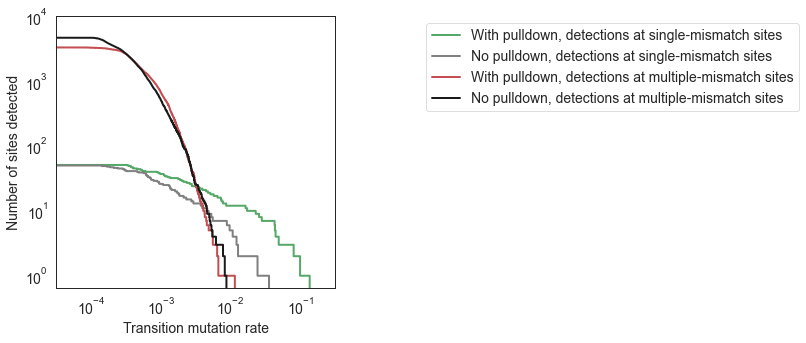

In [63]:
# plot number of single-mismatch and multiple-mismatch loci for each sample as a function of mutational signal

# get signal at single-mismatch loci for sample with pulldown
singleMMsignal = np.array([withPulldownBases[i][transition[i]] for i in locs])
# remove on-target loci
singleMMsignal = singleMMsignal[singleMMsignal < 0.4]
# get signal at multiple-mismatch loci for sample with pulldown
# loci are excluded from plotting if they are close to a single-mismatch locus
# this is due to mutational signal that could arise in such loci due to dPTP/dKTP at an off-target nick as opposed to noise
multipleMMsignal = np.array([withPulldownBases[i][transition[i]] for i in range(len(plasmidReference)) if min(abs(i - np.array(locs))) > 10])
numSingle1 = []
numMultiple1 = []
mutSig1 = []
# loop through signal intensity values, removing lowest value until none are left
while singleMMsignal.size or multipleMMsignal.size:
    # save number of loci above the current signal level
    numSingle1.append(singleMMsignal.size)
    numMultiple1.append(multipleMMsignal.size)
    # identify minimum signal level in current set
    if multipleMMsignal.size:
        minSig = min(min(singleMMsignal), min(multipleMMsignal))
    else:
        minSig = min(singleMMsignal)
    # save minimum signal level in current set
    mutSig1.append(minSig)
    # remove all loci that are at the minimum signal level
    multipleMMsignal = multipleMMsignal[multipleMMsignal > minSig]
    singleMMsignal = singleMMsignal[singleMMsignal > minSig]
# for step-wise plot, save that there are 0 loci above the maximum signal level
numSingle1.append(0)
numMultiple1.append(0)
mutSig1.append(mutSig1[-1])

# get signal at single-mismatch loci for sample without pulldown
singleMMsignal = np.array([noPulldownBases[i][transition[i]] for i in locs])
# remove on-target loci
singleMMsignal = singleMMsignal[singleMMsignal < 0.2]
# get signal at multiple-mismatch loci for sample without pulldown
# loci are excluded from plotting if they are close to a single-mismatch locus
# this is due to mutational signal that could arise in such loci due to dPTP/dKTP at an off-target nick as opposed to noise
multipleMMsignal = np.array([noPulldownBases[i][transition[i]] for i in range(len(plasmidReference)) if min(abs(i - np.array(locs))) > 10])
numSingle2 = []
numMultiple2 = []
mutSig2 = []
# loop through signal intensity values, removing lowest value until none are left
while singleMMsignal.size or multipleMMsignal.size:
    # save number of loci above the current signal level
    numSingle2.append(singleMMsignal.size)
    numMultiple2.append(multipleMMsignal.size)
    # identify minimum signal level in current set
    if multipleMMsignal.size:
        minSig = min(min(singleMMsignal), min(multipleMMsignal))
    else:
        minSig = min(singleMMsignal)
    # save minimum signal level in current set
    mutSig2.append(minSig)
    # remove all loci that are at the minimum signal level
    multipleMMsignal = multipleMMsignal[multipleMMsignal > minSig]
    singleMMsignal = singleMMsignal[singleMMsignal > minSig]
# for step-wise plot, save that there are 0 loci above the maximum signal level
numSingle2.append(0)
numMultiple2.append(0)
mutSig2.append(mutSig2[-1])

plt.figure(figsize = (5, 5))
# plot single-mismatch, with pulldown data in green
plt.step(mutSig1, numSingle1, c = green)
# plot single-mismatch, without pulldown data in gray
plt.step(mutSig2, numSingle2, c = 'gray')
# plot multiple-mismatch, with pulldown data in red
plt.step(mutSig1, numMultiple1, c = red)
# plot multiple-mismatch, without pulldown data in black
plt.step(mutSig2, numMultiple2, c = 'k')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Transition mutation rate', fontsize = 14)
plt.xticks(fontsize = 14)
plt.ylabel('Number of sites detected', fontsize = 14)
plt.yticks([1, 10, 100, 1000, 10000], fontsize = 14)
plt.xlim([0.000031623, 0.31623])
plt.legend(['With pulldown, detections at single-mismatch sites', 'No pulldown, detections at single-mismatch sites', 'With pulldown, detections at multiple-mismatch sites', 'No pulldown, detections at multiple-mismatch sites'], bbox_to_anchor = (1.3, 1), loc = 'upper left', fontsize = 14)

if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S8C.pdf', bbox_inches = 'tight', transparent = 'True')

### Figure S9

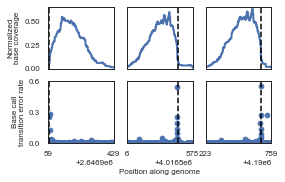

In [64]:
# plot read coverage and transition mutation rate for the nick sites not shown in Fig. 5
# code for Fig. 5 must be run before this, since this utilizes that data

plt.figure(figsize = (4, 2.5))

m = max(genomeCov)
count = 0

# data will be plotted for nicks 2, 6, and 8
# the rest of the relevant data is plotted in Fig. 5
for i in [2, 6, 8]:
    count += 1
    # identify MACS2 peak that contains the relevant nick
    peak = peaks[(peaks.start < calledNicks[i]) & (peaks.end > calledNicks[i])].iloc[0]
    plt.subplot(2, 3, count)
    plt.xticks([])
    plt.ylim((0, 0.65))
    plt.xlim([peak.start, peak.end])
    # normalize coverage data to be between 0 and 1, then plot
    plt.plot(range(peak.start, peak.end + 1), genomeCov[peak.start:peak.end + 1] / m)
    if count == 1:
        plt.ylabel('Normalized\nbase coverage')
        plt.yticks([0, 0.25, 0.5])
    else:
        plt.yticks([])
    # put a black dashed line at the nick site
    plt.axvline(calledNicks[i], ls = 'dashed', color = 'black', lw = 1.5)
    
    plt.subplot(2, 3, count + 3)
    plt.xlim([peak.start, peak.end])
    plt.ylim([0, 0.6])
    plt.xticks([peak.start, peak.end], horizontalalignment = 'center')
    # calculate and plot transition mutation rate
    transition = baseTransitions(genomeReference[peak.start:peak.end + 1])
    plt.scatter(range(peak.start, peak.end + 1), [genomeBases[i + peak.start][transition[i]] for i in range(len(transition))], s = 24)
    if count == 1:
        plt.ylabel('Base call\ntransition error rate')
        plt.yticks([0, 0.3, 0.6])
        plt.gca().get_xaxis().get_major_formatter().set_useOffset(2646900)
    else:
        plt.yticks([])
        if count == 2:
            plt.xlabel('\nPosition along genome')
            plt.gca().get_xaxis().get_major_formatter().set_useOffset(4016500)
    # put a black dashed line at the nick site
    plt.axvline(calledNicks[i], ls = 'dashed', color = 'black', lw = 1.5)
            
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S9A.pdf', bbox_inches = 'tight', transparent = 'True')

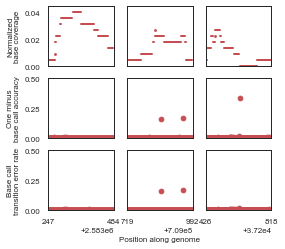

In [65]:
# plot read coverage and mutational signals for sites in the E. coli genome data where nicks weren't identified
# code for Fig. 5 must be run before this, since this utilizes that data

# the following peaks were chosen for their display of no non-consecutive, and non-transition mutational signals respectively
badPeaks = peaks.loc[[1734, 501, 27]]

m = max(genomeCov)
plt.figure(figsize = (4, 3.75))
        
count = 0
count2 = 0
for _, peak in badPeaks.iterrows():
    plt.subplot(3, 3, count2 + 1)
    plt.xticks([])
    plt.ylim((0, 0.045))
    plt.xlim(peak.start, peak.end + 1)
    # normalize coverage data to be between 0 and 1, then plot
    toPlot = genomeCov[peak.start:peak.end + 1] / m
    jumps = np.where(toPlot[1:] != toPlot[:-1])[0]
    plt.plot([peak.start, peak.start + jumps[0]], [toPlot[0], toPlot[jumps[0]]], c = red)
    for i in range(1, len(jumps)):
        plt.plot([peak.start + jumps[i - 1] + 1, peak.start + jumps[i]], [toPlot[jumps[i - 1] + 1], toPlot[jumps[i]]], c = red)
        if jumps[i - 1] + 1 == jumps[i]:
            plt.scatter(peak.start + jumps[i], toPlot[jumps[i]], s = 4, c = [red])
    if count2 == 0:
        plt.ylabel('Normalized\nbase coverage')
        plt.yticks([0, 0.02, 0.04])
    else:
        plt.yticks([])

    plt.subplot(3, 3, count2 + 4)
    plt.xlim([peak.start, peak.end + 1])
    plt.ylim([0, 0.5])
    # calculate and plot base call accuracy
    acc = [1 - genomeBases[i][genomeReference[i]] for i in range(peak.start, peak.end + 1)]
    plt.scatter(range(peak.start, peak.end + 1), np.nan_to_num(acc), s = 24, c = [red])
    plt.xticks([])
    if count2 == 0:
        plt.ylabel('One minus\nbase call accuracy')
        plt.yticks([0, 0.25, 0.5])
    else:
        plt.yticks([])
            
    plt.subplot(3, 3, count2 + 7)
    # calculate and plot transition mutation rate
    transition = baseTransitions(genomeReference[peak.start:peak.end + 1])
    pkSignal2 = [genomeBases[peak.start + i][transition[i]] for i in range(len(transition))]
    plt.scatter(range(peak.start, peak.end + 1), np.nan_to_num(pkSignal2), s = 24, c = [red])
    plt.xlim([peak.start, peak.end + 1])
    plt.ylim([0, 0.5])
    plt.xticks([peak.start, peak.end], horizontalalignment = 'center')
    if count2 == 0:
        plt.ylabel('Base call\ntransition error rate')
        plt.yticks([0, 0.25, 0.5])
    else:
        plt.yticks([])
        if count2 == 1:
            plt.xlabel('\nPosition along genome')
            plt.gca().get_xaxis().get_major_formatter().set_useOffset(709000)
        else:
            plt.gca().get_xaxis().get_major_formatter().set_useOffset(37200)
            
    count2 += 1
    
if printFigures:
    plt.savefig(figurePrint_dir + 'Fig_S9B.pdf', bbox_inches = 'tight', transparent = 'True')